# Chess Game Analysis: Building My First ML Pipeline

**Course:** CS156 - Machine Learning Pipeline Assignment 1  
**Date:** February 2026

---

## Why Chess?

I don't want to just do an assignment and get grades. I want to go through my process of learning through something I really love and care about.

**I love chess.** I've been playing it on and off since childhood, and it's one of those things that has stayed with me through different phases of my life. Recently, I've noticed something frustrating: my progress has stalled. I'm not improving like I used to, and my rating seems stuck. That got me thinking—what if I could use machine learning to actually understand my own play and find ways to improve?

So for this assignment, I decided to build my first ML pipeline about something that genuinely matters to me: my chess journey. I want a model that can help me improve my performance and increase my ratings.

I've collected data from three different accounts across my life:

| Era | Platform | Account | Games | Rating |
|-----|----------|---------|-------|--------|
| Childhood | Chess.com | Abdulrahmansoli | 1,013 | ~700-815 |
| High School | Lichess | Abdulrahmansoli | 259 | ~1,300-1,578 |
| Present | Chess.com | AbdulrahmanSoliman2 | 169 | ~1,000-1,200 |

## The Models I Want to Build

Since I want to actually improve at chess, I've thought about what models would be most useful. Here's my plan:

### Main Models (Deep Focus)

These are the ones I want to explore thoroughly:

1. **Outcome Prediction from First X Moves + Context** - Can I predict if I'll win or lose based on how the opening goes and the game context? This could help me understand which openings and early patterns lead to success for me.

2. **Tilt Detection Model** - Do I play worse after losing? Is there a pattern to when I go on tilt? If I can detect this, I can learn when to take breaks.

3. **Engine-Based Early Blunder Model** - Using engine analysis, can I predict when I'm likely to make a blunder early in the game? What conditions lead to my mistakes?

### Smaller Analysis Modules (For Later)

These are quick but potentially valuable analyses I might explore if I have time:

- **Color Effect** - Do I perform differently as White vs Black? A controlled expected-score analysis.
- **Time-of-Day Effect** - When do I play best? Using cyclic features and confidence bands.
- **Opening Recommender** - Which openings should I focus on? (Bucketing openings by type)

*I'm honestly not 100% sure about the smaller models yet—I'll see how the main ones go first.*

## What This Notebook Covers

This notebook handles the **data ingestion, cleaning, and feature engineering** that I'll need for any of these models. The preprocessing is model-agnostic—once I have clean features extracted from my games, I can plug them into whatever model makes sense.

---

In [35]:
import os, re, warnings
from datetime import datetime
import chess
import chess.pgn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

warnings.filterwarnings('ignore')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Libraries loaded successfully!")

Libraries loaded successfully!


Here's a quick sketch of what this pipeline looks like end-to-end, before I get into the details:

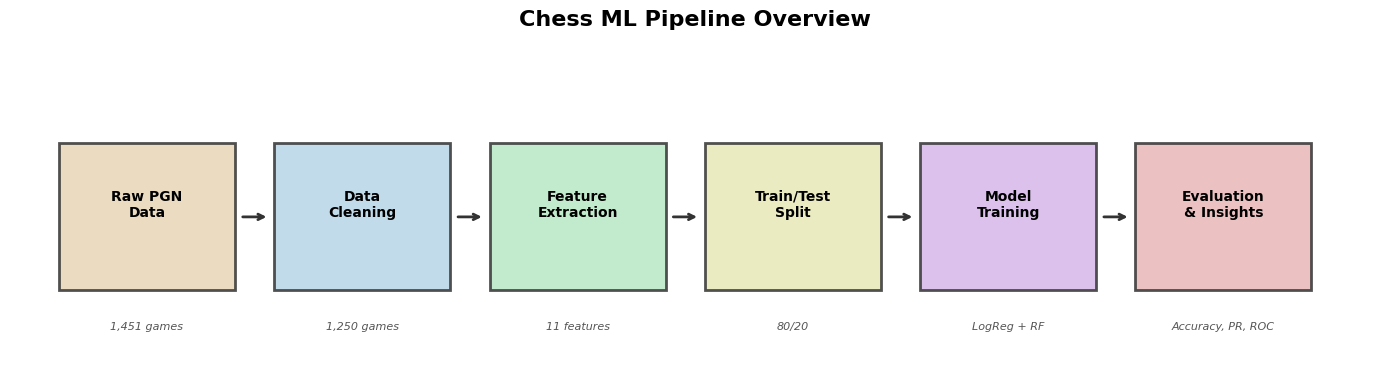

In [36]:
# Pipeline Illustration
fig, ax = plt.subplots(figsize=(14, 4))
ax.set_xlim(0, 14)
ax.set_ylim(0, 4)
ax.axis('off')
ax.set_title('Chess ML Pipeline Overview', fontsize=16, fontweight='bold', pad=20)

# Define pipeline stages
stages = [
    {'name': 'Raw PGN\nData', 'x': 0.5, 'color': '#E8D5B7', 'desc': '1,451 games'},
    {'name': 'Data\nCleaning', 'x': 2.7, 'color': '#B7D5E8', 'desc': '1,250 games'},
    {'name': 'Feature\nExtraction', 'x': 4.9, 'color': '#B7E8C4', 'desc': '11 features'},
    {'name': 'Train/Test\nSplit', 'x': 7.1, 'color': '#E8E8B7', 'desc': '80/20'},
    {'name': 'Model\nTraining', 'x': 9.3, 'color': '#D5B7E8', 'desc': 'LogReg + RF'},
    {'name': 'Evaluation\n& Insights', 'x': 11.5, 'color': '#E8B7B7', 'desc': 'Accuracy, PR, ROC'},
]

box_w, box_h = 1.8, 1.8

for i, s in enumerate(stages):
    # Draw box
    rect = plt.Rectangle((s['x'], 1.1), box_w, box_h, 
                          linewidth=2, edgecolor='#333', facecolor=s['color'],
                          alpha=0.85, zorder=2)
    rect.set_clip_on(False)
    ax.add_patch(rect)
    # Stage name
    ax.text(s['x'] + box_w/2, 2.15, s['name'], ha='center', va='center',
            fontsize=10, fontweight='bold', zorder=3)
    # Description
    ax.text(s['x'] + box_w/2, 0.65, s['desc'], ha='center', va='center',
            fontsize=8, fontstyle='italic', color='#555', zorder=3)
    # Arrow (except last)
    if i < len(stages) - 1:
        ax.annotate('', xy=(stages[i+1]['x'] - 0.05, 2.0),
                    xytext=(s['x'] + box_w + 0.05, 2.0),
                    arrowprops=dict(arrowstyle='->', color='#333', lw=2),
                    zorder=1)

plt.tight_layout()
plt.show()

## oop choice

Before diving into the code, I want to briefly explain why I chose to use an object-oriented programming (OOP) approach for this project. OOP allows me to encapsulate related data and functionality into classes, which can make my code more organized, reusable, and easier to maintain. 

For example, I can create a `ChessPipeline` class that contains methods for each step of the pipeline (data loading, cleaning, feature extraction, model training, etc.). This way, I can easily reuse the same pipeline structure for different datasets or models by simply creating new instances of the class. 

Additionally, OOP allows me to manage state more effectively, which can be helpful when I want to keep track of intermediate results or configurations throughout the pipeline. Overall, I believe that using OOP will help me build a more robust and scalable chess ML pipeline.

---

## Section 2: Data Ingestion

I needed to get all my chess games from different platforms into one place. For Chess.com, I wrote a download script using their public API ([`download_chess_pgn.py`](https://github.com/Abdulrahmansoliman/Chess-ML-pipeline/blob/main/download_chess_pgn.py)). Lichess was simpler — just export and download.

All chess games come in PGN (Portable Game Notation) format, which has headers (player names, ratings, date, time control, result) and the actual moves in algebraic notation like `e4 e5 Nf3 Nc6...`. I'm using classes to help organize the loading code since I have three different accounts to handle.

In [37]:
from dataclasses import dataclass
from typing import Optional, List, Dict, Any


@dataclass
class ChessAccount:
    """
    Represents a chess account with its metadata.
    
    Attributes:
        account_id: Unique identifier for the account
        era: The period of my life (childhood, highschool, present)
        platform: Chess platform (chesscom, lichess)
        username: My username on the platform
        pgn_path: Path to the PGN file containing games
    """
    account_id: str
    era: str
    platform: str
    username: str
    pgn_path: str


# My chess accounts across different eras
# Chess.com data downloaded using: https://github.com/Abdulrahmansoliman/Chess-ML-pipeline/blob/main/download_chess_pgn.py
ACCOUNTS = [
    ChessAccount("childhood", "childhood", "chesscom", "Abdulrahmansoli", 
                 "PGN-data/chess_com_childhood_abdulrahmansoli.pgn"),
    ChessAccount("highschool", "highschool", "lichess", "Abdulrahmansoli", 
                 "PGN-data/lichess_Abdulrahmansoli_2026-02-12.pgn"),
    ChessAccount("present", "present", "chesscom", "AbdulrahmanSoliman2", 
                 "PGN-data/chess_com_current_abdulrahmansoliman2.pgn")
]

print(f"Configured {len(ACCOUNTS)} accounts")
for acc in ACCOUNTS:
    print(f"  - {acc.era}: {acc.username} ({acc.platform})")

Configured 3 accounts
  - childhood: Abdulrahmansoli (chesscom)
  - highschool: Abdulrahmansoli (lichess)
  - present: AbdulrahmanSoliman2 (chesscom)


Before loading games I need some helper functions to parse the raw PGN data — things like figuring out the outcome from my perspective, extracting time controls, and converting dates. I grouped these as static methods in a `PGNParser` class just to keep them together.

In [38]:
class PGNParser:
    """
    Utility class for parsing PGN game data.
    Contains static methods for parsing game results, time controls, and dates.
    """
    
    @staticmethod
    def get_outcome(result: str, my_color: str) -> Optional[str]:
        """
        Determine the game outcome from my perspective.
        
        Args:
            result: Game result string (e.g., '1-0', '0-1', '1/2-1/2')
            my_color: The color I played ('white' or 'black')
            
        Returns:
            'win', 'loss', 'draw', or None if result is invalid
        """
        if result not in {'1-0', '0-1', '1/2-1/2'}:
            return None
        if result == '1/2-1/2':
            return 'draw'
        if (result == '1-0' and my_color == 'white') or (result == '0-1' and my_color == 'black'):
            return 'win'
        return 'loss'
    
    @staticmethod
    def parse_time_control(tc: str) -> tuple:
        """
        Parse time control string into base time and increment.
        
        Args:
            tc: Time control string (e.g., '300+5', '600')
            
        Returns:
            Tuple of (base_seconds, increment_seconds) or (None, None) if invalid
        """
        if not tc or tc in {'-', '?'}:
            return (None, None)
        
        # Format: base+increment (e.g., '300+5')
        match = re.match(r'^(\d+)\+(\d+)$', tc)
        if match:
            return int(match.group(1)), int(match.group(2))
        
        # Format: base only (e.g., '600')
        match = re.match(r'^(\d+)$', tc)
        if match:
            return int(match.group(1)), 0
        
        return (None, None)
    
    @staticmethod
    def parse_datetime(headers: dict) -> Optional[datetime]:
        """
        Extract datetime from PGN headers.
        
        Args:
            headers: Dictionary of PGN headers
            
        Returns:
            datetime object or None if parsing fails
        """
        date_str = headers.get('UTCDate') or headers.get('Date')
        time_str = headers.get('UTCTime') or headers.get('Time')
        
        if not date_str or date_str in {'????.??.??'}:
            return None
        
        try:
            if time_str and time_str not in {'??:??:??'}:
                return datetime.strptime(f'{date_str} {time_str}', '%Y.%m.%d %H:%M:%S')
            return datetime.strptime(date_str, '%Y.%m.%d')
        except ValueError:
            return None
    
    @staticmethod
    def safe_int(value) -> Optional[int]:
        """Safely convert a value to int, returning None on failure."""
        try:
            return int(value)
        except (ValueError, TypeError):
            return None



The `PGNLoader` reads through each PGN file and builds a structured row for every game — identifying which color I played, extracting ratings and time controls, computing rating difference, and converting moves to UCI format. After loading all three accounts, I sort everything by date since game order matters for things like tilt detection later.

In [39]:
class PGNLoader:
    """
    Loads and parses chess games from PGN files.
    
    This class handles reading PGN files and extracting game data
    into a structured format for analysis.
    """
    
    def __init__(self, account: ChessAccount):
        """
        Initialize the loader with a chess account.
        
        Args:
            account: ChessAccount object containing account metadata
        """
        self.account = account
        self.parser = PGNParser()
    
    def load_games(self) -> pd.DataFrame:
        """
        Load all games from the PGN file.
        
        Returns:
            DataFrame with parsed game data
        """
        games = []
        username_lower = self.account.username.lower()
        
        with open(self.account.pgn_path, 'r', encoding='utf-8', errors='ignore') as f:
            while True:
                game = chess.pgn.read_game(f)
                if game is None:
                    break
                
                game_data = self._parse_game(game, username_lower)
                if game_data:
                    games.append(game_data)
        
        return pd.DataFrame(games)
    
    def _parse_game(self, game, username_lower: str) -> Optional[Dict[str, Any]]:
        """
        Parse a single game into a dictionary.
        
        Args:
            game: Chess game object from python-chess
            username_lower: Lowercase username to identify my games
            
        Returns:
            Dictionary with game data or None if game should be skipped
        """
        headers = game.headers
        
        # Determine which color I played
        white = (headers.get('White') or '').lower()
        black = (headers.get('Black') or '').lower()
        
        if white == username_lower:
            my_color = 'white'
            my_elo = headers.get('WhiteElo')
            opp_elo = headers.get('BlackElo')
        elif black == username_lower:
            my_color = 'black'
            my_elo = headers.get('BlackElo')
            opp_elo = headers.get('WhiteElo')
        else:
            return None  # Not my game
        
        # Get game result from my perspective
        result = headers.get('Result', '')
        outcome = PGNParser.get_outcome(result, my_color)
        if outcome is None:
            return None  # Invalid result
        
        # Parse time control
        tc = headers.get('TimeControl')
        base_sec, inc_sec = PGNParser.parse_time_control(tc)
        
        # Get moves
        moves = list(game.mainline_moves())
        
        # Parse ratings
        my_elo_int = PGNParser.safe_int(my_elo)
        opp_elo_int = PGNParser.safe_int(opp_elo)
        rating_diff = (my_elo_int - opp_elo_int) if (my_elo_int and opp_elo_int) else None
        
        return {
            'account_id': self.account.account_id,
            'era': self.account.era,
            'platform': self.account.platform,
            'game_datetime': PGNParser.parse_datetime(headers),
            'me_color': my_color,
            'result_raw': result,
            'outcome_me': outcome,
            'time_control': tc,
            'base_sec': base_sec,
            'inc_sec': inc_sec,
            'me_elo': my_elo_int,
            'opp_elo': opp_elo_int,
            'rating_diff': rating_diff,
            'eco': headers.get('ECO'),
            'opening': headers.get('Opening'),
            'n_plies': len(moves),
            'moves_uci': ' '.join(m.uci() for m in moves)
        }


# Load games from all accounts
print("Loading PGN files...")
games_list = []

for account in ACCOUNTS:
    loader = PGNLoader(account)
    df = loader.load_games()
    print(f"  {account.era}: {len(df)} games")
    games_list.append(df)

df_games = pd.concat(games_list, ignore_index=True)

# Sort chronologically - important for time-series/tilt analysis
df_games = df_games.sort_values('game_datetime').reset_index(drop=True)

print(f"\nTotal: {len(df_games)} games")
df_games.head()

Loading PGN files...
  childhood: 1013 games
  highschool: 269 games
  present: 169 games

Total: 1451 games


,account_id,era,platform,game_datetime,me_color,result_raw,outcome_me,time_control,base_sec,inc_sec,me_elo,opp_elo,rating_diff,eco,opening,n_plies,moves_uci
0,childhood,childhood,chesscom,2019-07-17 11:55:15,white,0-1,loss,600,600.0,0.0,741,1152.0,-411.0,A00,None,34,e2e3 e7e5 f1e2 b8c6 a2a3 d7d5 b2b4 g8f6 b4b5 c...
1,childhood,childhood,chesscom,2019-07-17 11:59:52,black,1-0,loss,600,600.0,0.0,706,1154.0,-448.0,C00,None,27,e2e4 e7e6 g1f3 h7h6 b1c3 g7g5 h2h3 c7c6 f3h2 g...
2,childhood,childhood,chesscom,2019-07-17 12:04:32,black,1-0,loss,600,600.0,0.0,605,792.0,-187.0,C00,None,83,e2e4 e7e6 f2f4 d7d5 b1c3 c7c6 e4d5 c6d5 d1e2 d...
3,childhood,childhood,chesscom,2019-07-17 18:44:28,white,0-1,loss,600,600.0,0.0,522,717.0,-195.0,A00,None,54,e2e3 b7b6 d2d4 b8c6 d4d5 e7e6 d5c6 d7c6 f1d3 f...
4,childhood,childhood,chesscom,2019-07-17 19:05:43,white,1-0,win,600,600.0,0.0,614,553.0,61.0,A00,None,9,e2e3 c7c6 f1d3 d8b6 d1f3 b6c5 e1d1 c5c2 d1c2


---

## Section 3: Data Cleaning

Not all games are worth analyzing. Bullet games (under 3 minutes) are basically just premoves and reflexes, not real chess thinking. Games where someone disconnects after a few moves give me nothing to learn from either. I'm keeping blitz (3-10 min), rapid (10-30 min), and classical (30+ min) — games where I actually had time to think.

The `DataCleaner` class filters out bullet games (`base_sec < 180`), early disconnects (`n_plies < 10`), and empty games. It also fixes ELO columns to nullable integers and adds a `time_category` column. I used a class with configurable thresholds so I can easily experiment with different cutoffs later.

In [40]:
class DataCleaner:
    """
    Cleans chess game data for analysis.
    
    Filters out games that don't reflect real chess thinking:
    - Bullet games (too fast)
    - Early disconnects
    - Empty/incomplete games
    """
    
    # Minimum time control in seconds (3 minutes = 180 seconds)
    MIN_TIME_SECONDS = 180
    
    # Minimum game length in plies
    MIN_PLIES = 10
    
    def __init__(self, df: pd.DataFrame):
        """
        Initialize cleaner with raw game data.
        
        Args:
            df: DataFrame with raw chess games
        """
        self.df_raw = df
        self.df_clean = None
    
    def clean(self, verbose: bool = True) -> pd.DataFrame:
        """
        Apply all cleaning filters.
        
        Args:
            verbose: Print progress messages
            
        Returns:
            Cleaned DataFrame
        """
        if verbose:
            print(f"Starting with {len(self.df_raw)} games")
        
        df = self.df_raw.copy()
        
        # Remove bullet games - too fast for meaningful analysis
        df = df[df['base_sec'] >= self.MIN_TIME_SECONDS]
        if verbose:
            print(f"After removing bullet games: {len(df)} games")
        
        # Remove early disconnects
        df = df[df['n_plies'] >= self.MIN_PLIES]
        if verbose:
            print(f"After removing early disconnects: {len(df)} games")
        
        # Remove empty games
        df = df[df['moves_uci'].str.len() > 0]
        if verbose:
            print(f"After removing empty games: {len(df)} games")
        
        # Fix data types
        df['me_elo'] = df['me_elo'].astype('Int64')
        df['opp_elo'] = df['opp_elo'].astype('Int64')
        
        # Add time category
        df['time_category'] = df['base_sec'].apply(self._categorize_time)
        
        self.df_clean = df
        
        if verbose:
            print(f"\nFinal: {len(df)} games ready for analysis")
        
        return df
    
    @staticmethod
    def _categorize_time(base_sec) -> str:
        """
        Categorize game by time control.
        Note: Bullet games are already filtered out.
        """
        if base_sec is None:
            return 'unknown'
        if base_sec < 600:    # 3-10 minutes
            return 'blitz'
        if base_sec < 1800:   # 10-30 minutes
            return 'rapid'
        return 'classical'     # 30+ minutes


# Clean the data
cleaner = DataCleaner(df_games)
df_clean = cleaner.clean()

Starting with 1451 games
After removing bullet games: 1311 games
After removing early disconnects: 1250 games
After removing empty games: 1250 games

Final: 1250 games ready for analysis


Quick check on class balance — draws are pretty rare in my games, so if there's too few of them a 3-class model won't work well. If that's the case I'll just do binary (win vs not-win) to start.

In [41]:
# Check class balance
print("\n--- Class Distribution ---")
print(df_clean['outcome_me'].value_counts())


--- Class Distribution ---
outcome_me
loss    704
win     502
draw     44
Name: count, dtype: int64


Before building features, I want to show why I can't just use the raw move sequences directly. There are three levels of granularity I could try: ECO codes (coarse buckets), opening names (medium), or the actual first N moves as a string (fine-grained). The problem is that as you get more specific, the data gets incredibly sparse — most move sequences only appear once. Let me demonstrate this.

In [42]:
def get_first_n_plies(moves_uci: str, n: int = 14) -> str:
    """Extract the first N plies from a UCI move string."""
    moves = moves_uci.split()[:n]
    return ' '.join(moves)

# Add column for first 14 plies (7 moves = opening phase)
df_clean['first_14_plies'] = df_clean['moves_uci'].apply(lambda x: get_first_n_plies(x, 14))

# Analyze at all three levels of granularity
print("=== Move Sequence Sparsity Analysis ===")
print(f"Total games: {len(df_clean)}")
print()

# Level 1: ECO codes
unique_eco = df_clean['eco'].nunique()
print(f"1. Unique ECO codes: {unique_eco}")
if unique_eco > 0:
    print(f"   Average games per ECO: {len(df_clean)/unique_eco:.1f}")
else:
    print("   (No ECO data available)")
print()

# Level 2: Opening names (may be None/NaN for many games)
unique_openings = df_clean['opening'].dropna().nunique()
print(f"2. Unique opening names: {unique_openings}")
if unique_openings > 0:
    print(f"   Average games per opening: {len(df_clean)/unique_openings:.1f}")
else:
    print("   (No opening name data available - platform didn't classify these games)")
print()

# Level 3: Raw move sequences (first 14 plies) - THIS IS THE KEY ANALYSIS
unique_sequences = df_clean['first_14_plies'].nunique()
print(f"3. Unique first-14-ply sequences: {unique_sequences}")
if unique_sequences > 0:
    print(f"   Average games per sequence: {len(df_clean)/unique_sequences:.1f}")
    print(f"   ⚠️ Uniqueness ratio: {unique_sequences/len(df_clean)*100:.1f}%")
print()

# Show the long tail at each level (only for non-empty columns)
print("--- Long Tail Analysis ---")
for name, col in [('ECO codes', 'eco'), ('Move sequences', 'first_14_plies')]:
    counts = df_clean[col].value_counts()
    if len(counts) > 0:
        rare = (counts <= 5).sum()
        very_rare = (counts == 1).sum()
        print(f"{name}: {rare} with ≤5 games ({rare/len(counts)*100:.1f}%), {very_rare} appear only once ({very_rare/len(counts)*100:.1f}%)")
    else:
        print(f"{name}: No data available")

=== Move Sequence Sparsity Analysis ===
Total games: 1250

1. Unique ECO codes: 92
   Average games per ECO: 13.6

2. Unique opening names: 0
   (No opening name data available - platform didn't classify these games)

3. Unique first-14-ply sequences: 1249
   Average games per sequence: 1.0
   ⚠️ Uniqueness ratio: 99.9%

--- Long Tail Analysis ---
ECO codes: 57 with ≤5 games (62.0%), 33 appear only once (35.9%)
Move sequences: 1249 with ≤5 games (100.0%), 1248 appear only once (99.9%)


### Feature Extraction

Since raw move sequences are almost unique per game (as demonstrated above), I need to compress them into something a model can actually learn from. The `FeatureExtractor` class replays the first N plies of each game on a board and records what happened — not the exact moves, but the *type* of play.

I split the features into two groups:

**Context features** — things I know before the game starts:

| Feature | What it captures |
|---------|-----------------|
| `rating_diff` | My rating minus opponent's. Without this, the model could confuse "good opening" with "weak opponent." |
| `base_sec` | Base time in seconds. My play style changes a lot between blitz and rapid. |
| `inc_sec` | Increment per move. |
| `is_white` | 1 if I played white. First-move advantage affects opening structure. |

**Behavioral features** — extracted only from the first N plies to avoid leaking the outcome:

| Feature | Type | What it captures |
|---------|------|-----------------|
| `my_castled_by_N` | Binary | Did I castle? (King safety) |
| `opp_castled_by_N` | Binary | Did opponent castle? (Affects whether I can attack their king) |
| `my_queen_moved_by_N` | Binary | Early queen move? (Often a bad habit at my level) |
| `my_pawn_moves_N` | Count | Pawn pushes in the opening (opening style) |
| `my_minor_moves_N` | Count | Knight + Bishop development (how fast I develop) |
| `my_captures_N` | Count | Early captures (aggression level) |
| `my_checks_N` | Count | Checks given early (tactical activity) |

The context features act as controls — they let the model learn opening patterns *after accounting for* opponent strength, time format, and color.

In [43]:
class FeatureExtractor:
    """
    Extracts features from chess games for ML modeling.
    
    Features are computed from the first N plies of each game,
    avoiding information leakage from the game outcome.
    
    Attributes:
        n_plies: Number of plies to analyze from game start
    """
    
    def __init__(self, n_plies: int = 14):
        """
        Initialize the feature extractor.
        
        Args:
            n_plies: Number of half-moves to analyze (default: 14 = ~7 full moves)
        """
        self.n_plies = n_plies
    
    def extract_game_features(self, moves_uci: str, me_color: str) -> Optional[Dict[str, Any]]:
        """
        Extract early-game behavior features from a single game.
        
        Args:
            moves_uci: Space-separated UCI moves string
            me_color: 'white' or 'black'
            
        Returns:
            Dictionary of features or None if game has invalid moves
        """
        try:
            board = chess.Board()
            moves = [chess.Move.from_uci(m) for m in moves_uci.split() if m]
            me_is_white = (me_color == 'white')
            
            # Binary features
            my_castled = 0
            opp_castled = 0
            my_queen_moved = 0
            
            # Count features
            my_pawn_moves = 0
            my_minor_moves = 0
            my_captures = 0
            my_checks = 0
            
            # Process first N plies
            for ply, move in enumerate(moves[:self.n_plies]):
                if move not in board.legal_moves:
                    return None
                
                is_my_turn = (board.turn == chess.WHITE) == me_is_white
                
                if is_my_turn:
                    piece_type = board.piece_type_at(move.from_square)
                    
                    # Binary features
                    if board.is_castling(move):
                        my_castled = 1
                    if piece_type == chess.QUEEN:
                        my_queen_moved = 1
                    
                    # Count features
                    if piece_type == chess.PAWN:
                        my_pawn_moves += 1
                    if piece_type in {chess.KNIGHT, chess.BISHOP}:
                        my_minor_moves += 1
                    if board.is_capture(move):
                        my_captures += 1
                    
                    board.push(move)
                    if board.is_check():
                        my_checks += 1
                else:
                    if board.is_castling(move):
                        opp_castled = 1
                    board.push(move)
            
            return {
                'my_castled_by_N': my_castled,
                'opp_castled_by_N': opp_castled,
                'my_queen_moved_by_N': my_queen_moved,
                'my_pawn_moves_N': my_pawn_moves,
                'my_minor_moves_N': my_minor_moves,
                'my_captures_N': my_captures,
                'my_checks_N': my_checks
            }
            
        except Exception:
            return None
    
    def extract_context_features(self, row: pd.Series) -> Dict[str, Any]:
        """
        Extract context features known before the game starts.
        
        Args:
            row: DataFrame row with game metadata
            
        Returns:
            Dictionary of context features
        """
        return {
            'rating_diff': row['rating_diff'] if pd.notna(row['rating_diff']) else 0,
            'base_sec': row['base_sec'] if pd.notna(row['base_sec']) else 0,
            'inc_sec': row['inc_sec'] if pd.notna(row['inc_sec']) else 0,
            'is_white': 1 if row['me_color'] == 'white' else 0
        }
    
    def transform(self, df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
        """
        Transform a DataFrame of games into a feature matrix.
        
        Args:
            df: DataFrame with columns: moves_uci, me_color, rating_diff, base_sec, inc_sec
            verbose: Print progress messages
            
        Returns:
            DataFrame with original data plus extracted features
        """
        if verbose:
            print(f"Extracting features from first {self.n_plies} plies...")
        
        feature_rows = []
        skipped = 0
        
        for idx, row in df.iterrows():
            game_features = self.extract_game_features(row['moves_uci'], row['me_color'])
            
            if game_features is None:
                skipped += 1
                continue
            
            context_features = self.extract_context_features(row)
            
            feature_rows.append({
                **row.to_dict(),
                **context_features,
                **game_features
            })
        
        df_features = pd.DataFrame(feature_rows)
        
        if verbose:
            print(f"Features extracted: {len(df_features)} games")
            if skipped > 0:
                print(f"Skipped {skipped} games with invalid moves")
        
        return df_features


# Extract features
extractor = FeatureExtractor(n_plies=14)
df_features = extractor.transform(df_clean)
df_features.head()

Extracting features from first 14 plies...
Features extracted: 1234 games
Skipped 16 games with invalid moves


,account_id,era,platform,game_datetime,me_color,result_raw,outcome_me,time_control,base_sec,inc_sec,...,time_category,first_14_plies,is_white,my_castled_by_N,opp_castled_by_N,my_queen_moved_by_N,my_pawn_moves_N,my_minor_moves_N,my_captures_N,my_checks_N
0,childhood,childhood,chesscom,2019-07-17 11:55:15,white,0-1,loss,600,600.0,0.0,...,rapid,e2e3 e7e5 f1e2 b8c6 a2a3 d7d5 b2b4 g8f6 b4b5 c...,1,0,0,0,6,1,0,0
1,childhood,childhood,chesscom,2019-07-17 11:59:52,black,1-0,loss,600,600.0,0.0,...,rapid,e2e4 e7e6 g1f3 h7h6 b1c3 g7g5 h2h3 c7c6 f3h2 g...,0,0,0,0,5,2,0,0
2,childhood,childhood,chesscom,2019-07-17 12:04:32,black,1-0,loss,600,600.0,0.0,...,rapid,e2e4 e7e6 f2f4 d7d5 b1c3 c7c6 e4d5 c6d5 d1e2 d...,0,0,0,0,6,1,1,0
3,childhood,childhood,chesscom,2019-07-17 18:44:28,white,0-1,loss,600,600.0,0.0,...,rapid,e2e3 b7b6 d2d4 b8c6 d4d5 e7e6 d5c6 d7c6 f1d3 f...,1,0,0,0,6,1,1,0
4,childhood,childhood,chesscom,2019-07-17 19:07:40,black,0-1,win,600,600.0,0.0,...,rapid,e2e4 e7e6 f1c4 c7c6 d2d3 b7b5 c4b3 a7a5 c2c3 a...,0,0,0,0,7,0,1,0


Let me verify this actually solved the sparsity problem. Before, almost every game had a unique first-14-ply sequence. After compressing into behavioral features, I should see way fewer unique combinations:

In [44]:
# Compare sparsity: raw sequences vs behavioral features
behavior_cols = ['my_castled_by_N', 'opp_castled_by_N', 'my_queen_moved_by_N',
                 'my_pawn_moves_N', 'my_minor_moves_N', 'my_captures_N', 'my_checks_N']

# Create a tuple of behavioral features for each game
df_features['behavior_tuple'] = df_features[behavior_cols].apply(tuple, axis=1)

unique_behaviors = df_features['behavior_tuple'].nunique()
# Get unique sequences from df_features (same dataset for fair comparison)
df_features['first_14_plies_temp'] = df_features['moves_uci'].apply(lambda x: get_first_n_plies(x, 14))
unique_sequences = df_features['first_14_plies_temp'].nunique()
df_features.drop('first_14_plies_temp', axis=1, inplace=True)

print("=== Sparsity Comparison ===")
print(f"Total games: {len(df_features)}")
print()
print(f"Raw move sequences (before): {unique_sequences} unique ({unique_sequences/len(df_features)*100:.1f}%)")
print(f"Behavioral features (after):  {unique_behaviors} unique ({unique_behaviors/len(df_features)*100:.1f}%)")
print()
print(f"✅ Compression ratio: {unique_sequences/unique_behaviors:.1f}x fewer categories")
print(f"✅ Average games per behavior pattern: {len(df_features)/unique_behaviors:.1f}")
print()
print("→ This is why behavioral features work: they group similar games together for learning!")

# Clean up temporary column
df_features.drop('behavior_tuple', axis=1, inplace=True)

=== Sparsity Comparison ===
Total games: 1234

Raw move sequences (before): 1233 unique (99.9%)
Behavioral features (after):  256 unique (20.7%)

✅ Compression ratio: 4.8x fewer categories
✅ Average games per behavior pattern: 4.8

→ This is why behavioral features work: they group similar games together for learning!


We can see that the number of unique move sequences is huge, but the number of unique feature combinations is much smaller, which means the model can actually learn patterns from the data. The Raw move sequence is too specific, but the behavioral features capture the underlying patterns in a way that allows the model to learn effectively. For example, many different move sequences can lead to the same behavioral features (e.g., I might castle on move 5 in one game and move my queen early in another, but both would have `my_castled_by_N=1` and `my_queen_moved_by_N=0`). 

## Section 5: Feature Design — Documenting My Choices

### What is Model 1 actually predicting?

Model 1 tries to answer: given what I know before the game (context) and what happens in the first N plies (behavior), what's the probability I win? The output is binary — win (1) vs not-win (0), where not-win lumps together losses and draws. I'm doing binary because draws are so rare in my data (only 44 out of ~1250 games) that a 3-class model wouldn't have enough examples to learn from.

### Plies vs moves

I count plies, not full moves. One ply = one player makes one move (like `e2e4`). So $N = 14$ plies is roughly the first 7 full moves. This matches the PGN move list directly and avoids any ambiguity about what "move 7" means when White and Black alternate. For games that end early, I just compute features from $\min(N,\;\text{available plies})$ instead of dropping the game.

### Why not raw move sequences?

Because the space explodes. If I model the exact first 7 moves, almost every game is unique — the model memorizes instead of learning. Compressing into behavioral features (development speed, castling, aggression) groups similar games together so generalization is possible.

### The feature matrix

I build a feature matrix $X$ with one row per game and one column per feature:

$$X \in \mathbb{R}^{n \times d}, \quad n \approx 1250 \text{ games}, \quad d = 11 \text{ features}$$

A single game $i$ looks like:

$$x_i = \begin{bmatrix} \underbrace{\text{rating\_diff},\; \text{base\_sec},\; \text{inc\_sec},\; \text{is\_white}}_{\text{context (4)}} ,\; \underbrace{\text{castled},\; \text{opp\_castled},\; \text{queen\_moved},\; \text{pawns},\; \text{minors},\; \text{captures},\; \text{checks}}_{\text{behavior (7)}} \end{bmatrix}$$

The target vector is binary:

$$y_i \in \{0, 1\}, \quad y_i = \begin{cases} 1 & \text{if I won} \\ 0 & \text{otherwise (loss or draw)} \end{cases}$$

### Context features (pre-game)

I include `rating_diff` $= \text{my\_elo} - \text{opp\_elo}$ because without it, the model might think some opening pattern "causes wins" when really I just faced a weaker opponent. `base_sec` and `inc_sec` matter because my play changes a lot between blitz and rapid. `is_white` controls for first-move advantage. These features act as controls so the model learns opening patterns *after accounting for* opponent strength and time format.

### Behavioral features (from first N plies)

The binary features (castled? queen moved?) are yes/no flags where a single occurrence already matters at my level. The count features (pawn moves, minor piece moves, captures, checks) measure activity level and opening style. I keep pawn counting simple — just total pawn moves, no per-file breakdown — to avoid overfitting with my small dataset. Same reason I don't track individual pieces: "did my b1 knight move?" adds detail without much benefit.

### Choosing N

I went with $N = 14$ plies (~7 full moves) as my starting point since that covers the critical opening phase. I'll experiment with $N = 20$ and $N = 30$ later to see if extending the window helps.

## Section 6: Model Implementation — Outcome Prediction

### 6.1 Setting up the model

Now that I have clean features from the first 14 plies, I can build the actual model. The question is: given a feature vector $x_i$ for game $i$, what's $P(\text{win} \mid x_i)$?

Each game is binary (win or not), so I model the outcome as:

$$y_i \mid x_i \;\sim\; \text{Bernoulli}(p_i), \qquad p_i = P(\text{win} \mid x_i)$$

Here's what each symbol maps to in my chess problem:

| Symbol | What it is | In my model |
|--------|-----------|-------------|
| $n$ | Number of games | ~1,234 (after cleaning) |
| $d$ | Number of features | 11 (4 context + 7 behavior) |
| $x_i \in \mathbb{R}^d$ | Feature vector for game $i$ | e.g. $[\underset{\text{rating\_diff}}{-120},\; \underset{\text{base\_sec}}{300},\; \underset{\text{inc\_sec}}{5},\; \underset{\text{is\_white}}{1},\; \underset{\text{castled}}{0},\; \ldots]$ |
| $y_i \in \{0, 1\}$ | Outcome of game $i$ | 1 = I won, 0 = I lost or drew |
| $w \in \mathbb{R}^d$ | Weight vector | One learned weight per feature (e.g. $w_1$ for `rating_diff`, $w_5$ for `castled`, …) |
| $b \in \mathbb{R}$ | Bias / intercept | Baseline log-odds of winning when all features are 0 |
| $p_i$ | Predicted win probability | e.g. $p_i = 0.63$ means "model thinks 63% chance I win game $i$" |

### 6.2 How logistic regression works

Logistic regression first computes a linear score for each game:

$$\eta_i = w^\top x_i + b = w_1 \cdot \text{rating\_diff}_i + w_2 \cdot \text{base\_sec}_i + \cdots + w_{11} \cdot \text{checks}_i + b$$

In matrix form for all $n$ games at once: $\eta = Xw + b$, where $X$ is my $(n \times d)$ feature matrix.

The problem is $\eta_i$ can be anything from $-\infty$ to $+\infty$ — for example, if I'm much higher rated and castled early, $\eta_i$ could be some large positive number like 2.8. But I need a probability in $(0, 1)$. The sigmoid function handles that:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

So the predicted win probability becomes:

$$p_i = \sigma(\eta_i) = \sigma(w^\top x_i + b)$$

A concrete example: if the model computes $\eta_i = 0.53$ for one of my games, then $p_i = \sigma(0.53) = \frac{1}{1 + e^{-0.53}} \approx 0.63$, meaning 63% predicted win chance.

### 6.3 Training: the loss function

To find the best $w$ and $b$, I minimize binary cross-entropy (which is just the negative log-likelihood of the Bernoulli model):

$$\mathcal{L}(w, b) = -\frac{1}{n}\sum_{i=1}^{n}\Big[y_i \log(p_i) + (1 - y_i)\log(1 - p_i)\Big]$$

Intuitively: when $y_i = 1$ (I won), the loss penalizes small $p_i$ — if the model said 10% win chance on a game I actually won, that's a big error. When $y_i = 0$ (I didn't win), it penalizes large $p_i$. Minimizing this across all my ~1,234 games finds the weights that make my observed wins and losses most probable.

With L2 regularization, the full objective becomes:

$$\mathcal{L}_{\text{reg}} = \mathcal{L}(w, b) + \frac{\lambda}{2n}\|w\|^2$$

where $\lambda$ controls how much we penalize large weights. This prevents any single feature (like `rating_diff`) from getting a disproportionately large weight and overfitting.

### 6.4 Why logistic regression first?

My target is binary, I only have ~1k games with ~11 features, so a simple model won't overfit too badly. Plus I can look at the learned weights $w$ and directly interpret them: a positive $w_j$ means that feature increases my predicted win probability, and after scaling, the magnitudes are comparable across features. It also gives me probabilities, not just yes/no, which is useful for ranking which openings give me the best chances. I can try fancier models after.

### 6.5 Connection to Bayesian thinking

Here's an interesting fact that I found: when sklearn uses L2 regularization (the penalty term above), it's already doing something Bayesian under the hood.

It's like saying before seeing any chess data, what should I believe about the weights? If I have no information, it's reasonable to expect most weights to be small — I shouldn't assume, say, that `my_queen_moved` has a huge impact compared to everything else.

This "small weights" belief is mathematically the same as having a prior that expects weights to be near zero. The regularization parameter $\lambda$ controls how strongly I believe this.

So sklearn's solution is finding the "most likely" weights given this prior belief plus my data. A full Bayesian approach would go further and give me uncertainty ranges — instead of saying "`my_queen_moved` has weight -0.15", it would say "the weight is probably between -0.23 and -0.07, with -0.15 being most likely."

For this first model, the point estimate is fine. But later I might want those uncertainty ranges to know which patterns I should actually trust vs which ones might just be noise.

#### Feature columns for Model 1:

```python
feature_cols = [
    'rating_diff', 'base_sec', 'inc_sec', 'is_white',
    'my_castled_by_N', 'opp_castled_by_N', 'my_queen_moved_by_N',
    'my_pawn_moves_N', 'my_minor_moves_N', 'my_captures_N', 'my_checks_N'
]
```

Converting outcome to binary: win=1, everything else=0. Draws are too rare (~44 games) for a 3-class approach.

In [45]:
# Create binary target: win=1, not-win=0
df_features['y_win'] = (df_features['outcome_me'] == 'win').astype(int)

print("Target distribution:")
print(df_features['y_win'].value_counts())
print(f"\nWin rate: {df_features['y_win'].mean():.2%}")

Target distribution:
y_win
0    734
1    500
Name: count, dtype: int64

Win rate: 40.52%


Locking the 11 features (4 context + 7 behavior) and filling missing values with 0.

In [46]:
# Lock feature columns for Model 1 v1
FEATURE_COLS = [
    'rating_diff', 'base_sec', 'inc_sec', 'is_white',
    'my_castled_by_N', 'opp_castled_by_N', 'my_queen_moved_by_N',
    'my_pawn_moves_N', 'my_minor_moves_N', 'my_captures_N', 'my_checks_N'
]

# Prepare feature matrix and target
X = df_features[FEATURE_COLS].fillna(0)
y = df_features['y_win'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {FEATURE_COLS}")

Feature matrix shape: (1234, 11)
Target shape: (1234,)

Features: ['rating_diff', 'base_sec', 'inc_sec', 'is_white', 'my_castled_by_N', 'opp_castled_by_N', 'my_queen_moved_by_N', 'my_pawn_moves_N', 'my_minor_moves_N', 'my_captures_N', 'my_checks_N']


80/20 train-test split, stratified to keep the same class balance in both sets. The test set stays completely untouched until final evaluation.

In [47]:
# Train/Test split - TEST SET STAYS UNTOUCHED
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"Training set: {X_train.shape[0]} games")
print(f"Test set: {X_test.shape[0]} games (HELD OUT)")
print(f"\nTrain win rate: {y_train.mean():.2%}")
print(f"Test win rate: {y_test.mean():.2%}")

Training set: 987 games
Test set: 247 games (HELD OUT)

Train win rate: 40.53%
Test win rate: 40.49%


Scaling features with `StandardScaler` so things like `rating_diff` (hundreds) and `my_castled_by_N` (0 or 1) are on the same footing. I fit the scaler on training data only and then transform test data using training statistics — otherwise I'd be leaking test set info.

In [48]:
# Scale features - fit on training data only!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use training statistics

print("Features scaled using training set statistics")
print(f"Training mean: {X_train_scaled.mean():.6f}")
print(f"Training std: {X_train_scaled.std():.6f}")

Features scaled using training set statistics
Training mean: 0.000000
Training std: 1.000000


### 6.5 Baseline: sklearn Logistic Regression

Training sklearn's `LogisticRegression` as a baseline, with 5-fold cross-validation on the training set to see how stable the accuracy is.

In [49]:
# Train sklearn baseline
sklearn_model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
sklearn_model.fit(X_train_scaled, y_train)

# Cross-validation on training set
cv_scores = cross_val_score(sklearn_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

Cross-validation accuracy: 0.719 (+/- 0.043)


### Test Set Evaluation

Alright, moment of truth. Let's see how this model actually performs on games it's never seen.

**The accuracy trap:** I can't just look at accuracy here. Why? Because I lose more than I win. If a model just predicted "you'll lose" for every single game, it would still get ~60% accuracy on my data. That's not useful at all.

So I'm measuring multiple metrics:

| Metric | What it tells me |
|--------|------------------|
| **Accuracy** | Overall % correct — but can be misleading with imbalanced classes |
| **Precision** | When the model says "win", is it right? (Can I trust its optimism?) |
| **Recall** | Of all my actual wins, how many did it catch? |
| **F1** | Harmonic mean of precision & recall — balances both |
| **ROC-AUC** | Can it rank games from "likely win" to "likely loss"? (0.5 = random, 1.0 = perfect) |
| **PR-AUC (Average Precision)** | Like ROC-AUC but focuses on the positive class — better for imbalanced data |
| **Calibration** | When it says 70% win probability, do I actually win ~70% of those games? |

### Evaluation Helper

I'm making a helper class to plot the metrics I care about. I'll reuse this for the other models later.

In [50]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve, average_precision_score


class ModelEvaluator:
    """
    Reusable evaluation framework for binary classifiers.
    
    Provides consistent metrics and visualizations across different models,
    enabling fair comparison throughout the project.
    """
    
    def __init__(self, model, X_test, y_test, feature_names=None, class_labels=None):
        """
        Initialize the evaluator with a trained model and test data.
        
        Args:
            model: Trained classifier with predict() and predict_proba() methods
            X_test: Test feature matrix
            y_test: True labels for test set
            feature_names: List of feature names (for coefficient plot)
            class_labels: Labels for classes, default ['not-win', 'win']
        """
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.feature_names = feature_names
        self.class_labels = class_labels or ['not-win', 'win']
        
        # Compute predictions
        self.y_pred = model.predict(X_test)
        self.y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    def plot_confusion_matrix(self, ax=None):
        """Plot confusion matrix for the test set."""
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 5))
        
        cm = confusion_matrix(self.y_test, self.y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=self.class_labels)
        disp.plot(ax=ax, cmap='Blues')
        ax.set_title('Confusion Matrix (Test Set)')
        return ax
    
    def plot_precision_recall_curve(self, ax=None):
        """Plot precision-recall curve showing tradeoffs at different thresholds."""
        if self.y_proba is None:
            print("Model does not support predict_proba, skipping PR curve")
            return None
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
        
        precision, recall, thresholds = precision_recall_curve(self.y_test, self.y_proba)
        ap_score = average_precision_score(self.y_test, self.y_proba)
        
        ax.plot(recall, precision, 'b-', linewidth=2, label=f'PR Curve (AP={ap_score:.3f})')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision-Recall Curve')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        
        # Add baseline (random classifier)
        baseline = self.y_test.mean()
        ax.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline ({baseline:.2f})')
        ax.legend()
        
        return ax
    
    def plot_roc_curve(self, ax=None):
        """
        Plot ROC (Receiver Operating Characteristic) curve with AUC score.
        
        ROC shows TPR (sensitivity) vs FPR (1-specificity) at all thresholds.
        AUC = 0.5 means random classifier, AUC = 1.0 means perfect.
        """
        if self.y_proba is None:
            print("Model does not support predict_proba, skipping ROC curve")
            return None
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
        
        from sklearn.metrics import roc_curve, roc_auc_score
        fpr, tpr, _ = roc_curve(self.y_test, self.y_proba)
        roc_auc = roc_auc_score(self.y_test, self.y_proba)
        
        ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
        ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
        ax.set_xlabel('False Positive Rate (1 - Specificity)')
        ax.set_ylabel('True Positive Rate (Sensitivity)')
        ax.set_title('ROC Curve')
        ax.legend(loc='lower right')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])
        
        return ax
    
    def plot_calibration_curve(self, n_bins=10, ax=None):
        """
        Plot calibration curve to check if predicted probabilities match actual frequencies.
        
        A well-calibrated model should have points close to the diagonal.
        """
        if self.y_proba is None:
            print("Model does not support predict_proba, skipping calibration curve")
            return None
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
        
        prob_true, prob_pred = calibration_curve(self.y_test, self.y_proba, n_bins=n_bins)
        
        ax.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
        ax.plot(prob_pred, prob_true, 's-', label='Model', markersize=8)
        ax.set_xlabel('Mean Predicted Probability')
        ax.set_ylabel('Fraction of Positives (Actual)')
        ax.set_title('Calibration Curve')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        
        return ax
    
    def plot_coefficients(self, ax=None, top_n=None):
        """
        Plot model coefficients (for logistic regression or linear models).
        
        Args:
            top_n: If specified, show only top N features by absolute coefficient
        """
        if not hasattr(self.model, 'coef_'):
            print("Model does not have coefficients, skipping coefficient plot")
            return None
        
        if self.feature_names is None:
            print("Feature names not provided, skipping coefficient plot")
            return None
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        
        coef_df = pd.DataFrame({
            'feature': self.feature_names,
            'coefficient': self.model.coef_[0]
        }).sort_values('coefficient', key=abs, ascending=False)
        
        if top_n:
            coef_df = coef_df.head(top_n)
        
        colors = ['green' if c > 0 else 'red' for c in coef_df['coefficient']]
        ax.barh(coef_df['feature'], coef_df['coefficient'], color=colors)
        ax.set_xlabel('Coefficient (positive = increases win probability)')
        ax.set_title('Feature Importance: What Predicts My Wins?')
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        
        return ax
    
    def full_report(self, figsize=(15, 10)):
        """
        Generate a complete evaluation report with all visualizations.
        """
        # Print text metrics
        print("=" * 50)
        print("MODEL EVALUATION REPORT")
        print("=" * 50)
        print(f"\nAccuracy: {accuracy_score(self.y_test, self.y_pred):.3f}")
        print(f"\nClassification Report:")
        print(classification_report(self.y_test, self.y_pred, target_names=self.class_labels))
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Plot all visualizations
        self.plot_confusion_matrix(ax=axes[0, 0])
        self.plot_precision_recall_curve(ax=axes[0, 1])
        self.plot_calibration_curve(ax=axes[1, 0])
        self.plot_coefficients(ax=axes[1, 1])
        
        plt.tight_layout()
        plt.show()
        
        return fig


# Create evaluator for the sklearn baseline model
evaluator = ModelEvaluator(
    model=sklearn_model,
    X_test=X_test_scaled,
    y_test=y_test,
    feature_names=FEATURE_COLS,
    class_labels=['not-win', 'win']
)

# Print text metrics
print("=" * 50)
print("MODEL EVALUATION REPORT")
print("=" * 50)
print(f"\nAccuracy: {accuracy_score(y_test, evaluator.y_pred):.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, evaluator.y_pred, target_names=['not-win', 'win']))

MODEL EVALUATION REPORT

Accuracy: 0.713

Classification Report:
              precision    recall  f1-score   support

     not-win       0.73      0.83      0.77       147
         win       0.68      0.54      0.60       100

    accuracy                           0.71       247
   macro avg       0.70      0.68      0.69       247
weighted avg       0.71      0.71      0.71       247



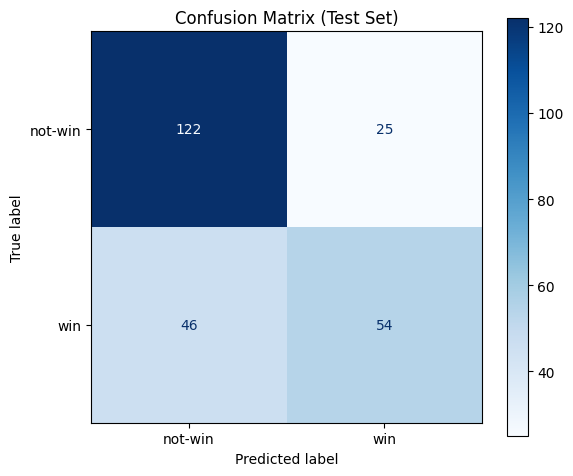

In [51]:
# Confusion matrix visualization
fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y_test, evaluator.y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['not-win', 'win'])
disp.plot(ax=ax, cmap='Blues')
ax.set_title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

### Confusion Matrix

Looking at the confusion matrix, my model is **conservative about predicting wins**. Here's what I see:

- **TN = 122**: Correctly predicted not-win
- **FP = 25**: Said I'd win but I didn't (false optimism)
- **FN = 46**: Said I wouldn't win but I actually did (missed opportunities)
- **TP = 54**: Correctly predicted win

So the model predicts "win" 79 times total (54 + 25), and gets it right 68% of the time (precision). But it misses 46 actual wins, meaning it only catches 54% of my wins (recall).

**What this means for me:** If I use this model as a "should I feel good about this opening?" indicator, I can trust it when it says "win" — but it's going to miss a lot of games I actually win. It's being cautious.

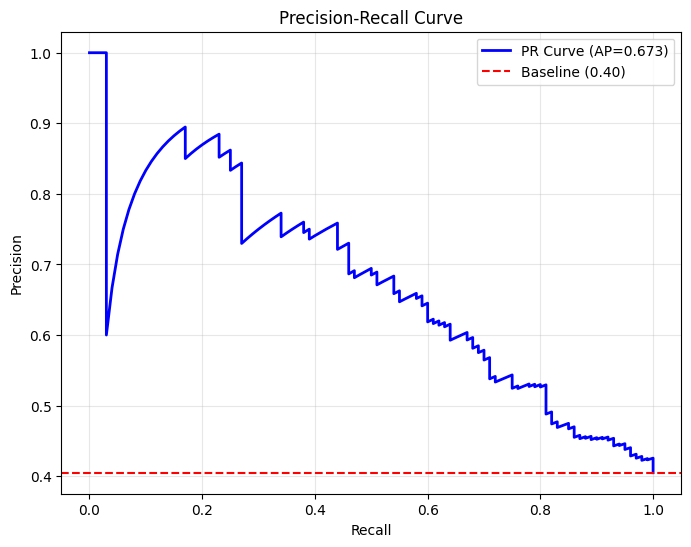

In [52]:
# Precision-Recall curve
evaluator.plot_precision_recall_curve()
plt.show()

### Precision-Recall Curve (This is my strongest result)

This is the plot I care most about. The **Average Precision (AP) = 0.673** compared to a baseline of ~0.40 (my win rate).

What this tells me: even if my hard predictions aren't perfect, the **probability ranking is useful**. If I sort my games by predicted win probability, the model does a solid job putting actual wins near the top.

This matters because I care about *which openings give me better chances*, not just a yes/no answer. The model can rank my game starts from "likely win" to "likely loss" much better than random.

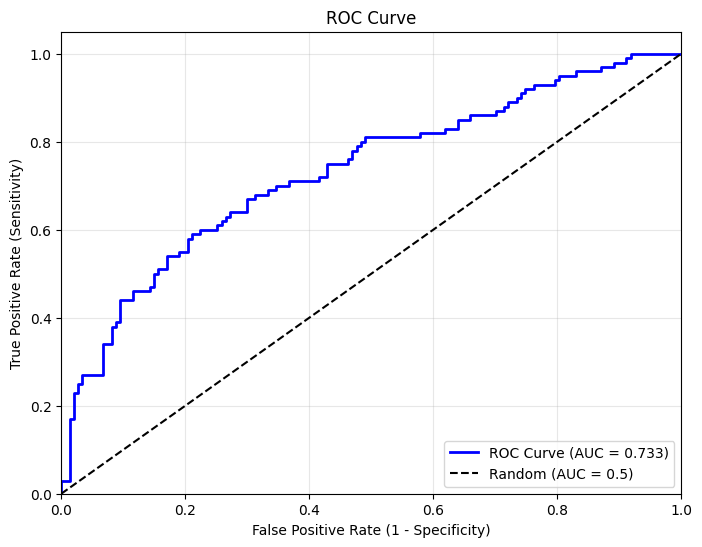

In [53]:
# ROC curve with AUC
evaluator.plot_roc_curve()
plt.show()

### ROC Curve

The ROC curve plots **True Positive Rate** (how many wins I catch) vs **False Positive Rate** (how often I falsely predict win) at all possible thresholds.

$$\text{TPR} = \frac{TP}{TP + FN}, \quad \text{FPR} = \frac{FP}{FP + TN}$$

- **AUC = 0.5**: Random guessing (diagonal line)
- **AUC = 1.0**: Perfect classifier

My model's ROC-AUC shows it's doing meaningfully better than chance at distinguishing wins from not-wins. This is a standard sanity check — if this was near 0.5, I'd know my features aren't predictive at all.

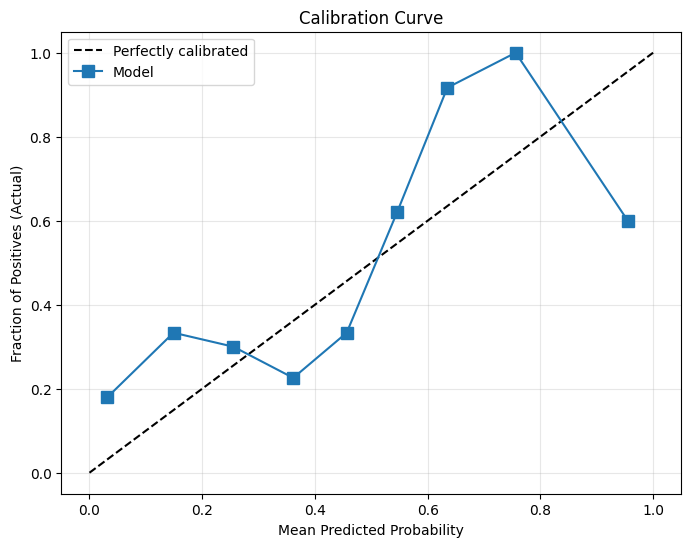

In [54]:
# Calibration curve
evaluator.plot_calibration_curve()
plt.show()

### Calibration Curve (Honest Assessment)

The calibration curve checks: "When the model says 60% win probability, do I actually win ~60% of those games?"

**Honest take:** My calibration isn't perfect. Some bins sit above the diagonal (model is underconfident — actual win rate higher than predicted) and some below (overconfident).

This happens because:
1. Only ~247 test points split into 10 bins = small/noisy bins
2. Logistic regression isn't always well-calibrated with class imbalance

**If I want to improve this later:** I could use `CalibratedClassifierCV` (isotonic or sigmoid calibration), or my planned Bayesian posterior predictive approach would naturally give better uncertainty estimates.

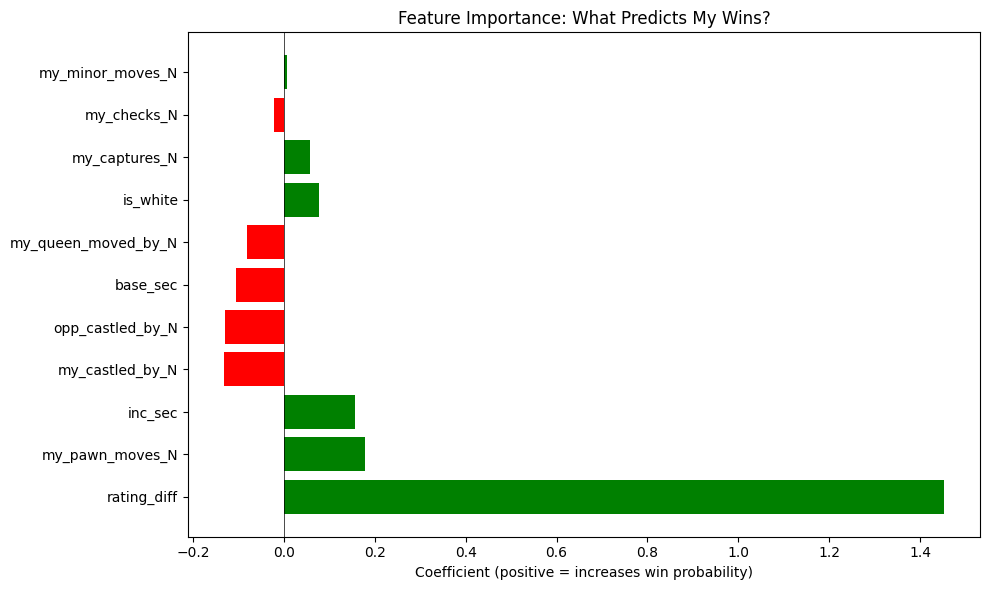


Feature Coefficients:
            feature  coefficient
        rating_diff     1.452741
    my_pawn_moves_N     0.177363
            inc_sec     0.156381
    my_castled_by_N    -0.132121
   opp_castled_by_N    -0.130318
           base_sec    -0.104694
my_queen_moved_by_N    -0.081962
           is_white     0.076996
      my_captures_N     0.058216
        my_checks_N    -0.022501
   my_minor_moves_N     0.007142


In [55]:
# Feature importance from coefficients
coef_df = pd.DataFrame({
    'feature': FEATURE_COLS,
    'coefficient': sklearn_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if c > 0 else 'red' for c in coef_df['coefficient']]
ax.barh(coef_df['feature'], coef_df['coefficient'], color=colors)
ax.set_xlabel('Coefficient (positive = increases win probability)')
ax.set_title('Feature Importance: What Predicts My Wins?')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\nFeature Coefficients:")
print(coef_df.to_string(index=False))

### Feature Importance — What Actually Predicts My Wins?

Since I used `StandardScaler`, the coefficients are comparable (each represents "1 standard deviation increase in this feature").

**Key findings:**

1. **`rating_diff` dominates** — No surprise. Playing weaker opponents = higher win probability. This is why I included it as a control variable.

2. **`my_queen_moved_by_N` is negative** — Early queen moves are associated with *lower* win probability. This matches chess advice: moving the queen early often leads to it getting harassed while the opponent develops.

3. **`opp_castled_by_N` is negative** — If my opponent castles early, my win odds drop. Makes sense: a castled king is safer, harder to attack.

4. **Some signs might look surprising** (e.g., if `my_castled_by_N` is negative). That's because these are *conditional* effects — "given rating diff, time control, and everything else..." Features are correlated, so individual coefficients shouldn't be read as "castling causes losses."

**Important:** These are *associations*, not causal effects. I can say "early queen moves are associated with my losses" but not "early queen moves cause my losses" — there could be confounders (like playing certain openings when I'm tilted).

## Section 8: Logistic Regression from Scratch

### Why Build It Myself?

I don't want to just call `model.fit()` and move on. I want to prove that I actually understand what's happening under the hood. Building logistic regression from scratch serves three purposes:

1. **Proving understanding**: If I can implement the math myself and get matching results, it means I truly understand the algorithm — not just the API.
2. **Validation**: Comparing my scratch model to sklearn's output acts as a cross-check. If both give similar coefficients and accuracy, I know the math is correct.
3. **Full control**: Writing my own training loop lets me track the loss at every iteration, visualize convergence, and experiment with things sklearn doesn't expose (custom learning rates, different regularization, etc.).

### The Math equations that I will implement

For a single sample $x_i$ with label $y_i \in \{0, 1\}$:

1. **Linear score**: $z_i = w^\top x_i + b$
2. **Sigmoid**: $\hat{y}_i = \sigma(z_i) = \frac{1}{1 + e^{-z_i}}$
3. **Binary cross-entropy loss**: $\mathcal{L} = -\frac{1}{n}\sum_{i=1}^{n}[y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)]$
4. **Gradients**:
   - $\frac{\partial \mathcal{L}}{\partial w} = \frac{1}{n} X^\top (\hat{y} - y)$
   - $\frac{\partial \mathcal{L}}{\partial b} = \frac{1}{n} \sum (\hat{y}_i - y_i)$
5. **Update rule** (gradient descent): $w \leftarrow w - \alpha \cdot \nabla_w \mathcal{L}$, same for $b$

I also add **L2 regularization** (same as sklearn's default) which adds $\frac{\lambda}{2n}\|w\|^2$ to the loss and $\frac{\lambda}{n}w$ to the weight gradient. The goal is that my from-scratch implementation should converge to essentially the same solution as sklearn.

### Logistic Regression as a "Neural Network"

Logistic regression is actually the simplest possible neural network — a single neuron with a sigmoid activation. Here's what it looks like visually:

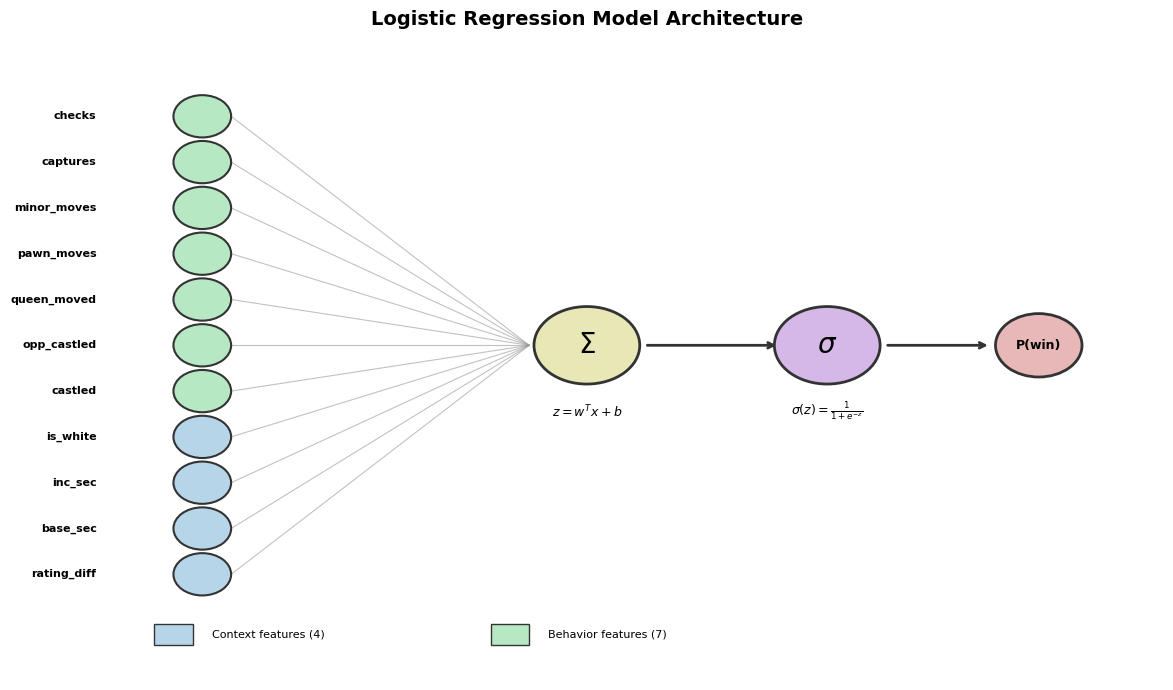

In [56]:
# Logistic Regression Architecture Diagram
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 8)
ax.axis('off')
ax.set_title('Logistic Regression Model Architecture', fontsize=14, fontweight='bold', pad=15)

# Input features (left side)
features = ['rating_diff', 'base_sec', 'inc_sec', 'is_white',
            'castled', 'opp_castled', 'queen_moved',
            'pawn_moves', 'minor_moves', 'captures', 'checks']

n_feat = len(features)
y_positions = np.linspace(0.5, 7, n_feat)

# Draw input nodes
for j, (feat, yp) in enumerate(zip(features, y_positions)):
    color = '#B7D5E8' if j < 4 else '#B7E8C4'  # blue=context, green=behavior
    circle = plt.Circle((1.0, yp), 0.3, color=color, ec='#333', lw=1.5, zorder=3)
    ax.add_patch(circle)
    ax.text(-0.1, yp, feat, ha='right', va='center', fontsize=8, fontweight='bold')
    # Connection line to sum node
    ax.plot([1.3, 4.4], [yp, 3.75], color='#999', lw=0.8, alpha=0.6, zorder=1)

# Sum node (weighted sum)
sum_circle = plt.Circle((5.0, 3.75), 0.55, color='#E8E8B7', ec='#333', lw=2, zorder=3)
ax.add_patch(sum_circle)
ax.text(5.0, 3.75, '$\\Sigma$', ha='center', va='center', fontsize=20, fontweight='bold', zorder=4)
ax.text(5.0, 2.8, '$z = w^T x + b$', ha='center', va='center', fontsize=9, fontstyle='italic')

# Arrow from sum to sigmoid
ax.annotate('', xy=(7.0, 3.75), xytext=(5.6, 3.75),
            arrowprops=dict(arrowstyle='->', color='#333', lw=2))

# Sigmoid node
sig_circle = plt.Circle((7.5, 3.75), 0.55, color='#D5B7E8', ec='#333', lw=2, zorder=3)
ax.add_patch(sig_circle)
ax.text(7.5, 3.75, '$\\sigma$', ha='center', va='center', fontsize=20, fontweight='bold', zorder=4)
ax.text(7.5, 2.8, '$\\sigma(z) = \\frac{1}{1+e^{-z}}$', ha='center', va='center', fontsize=9, fontstyle='italic')

# Arrow from sigmoid to output
ax.annotate('', xy=(9.2, 3.75), xytext=(8.1, 3.75),
            arrowprops=dict(arrowstyle='->', color='#333', lw=2))

# Output node
out_circle = plt.Circle((9.7, 3.75), 0.45, color='#E8B7B7', ec='#333', lw=2, zorder=3)
ax.add_patch(out_circle)
ax.text(9.7, 3.75, 'P(win)', ha='center', va='center', fontsize=9, fontweight='bold', zorder=4)

# Legend
legend_y = -0.5
ax.add_patch(plt.Rectangle((0.5, legend_y), 0.4, 0.3, color='#B7D5E8', ec='#333'))
ax.text(1.1, legend_y + 0.15, 'Context features (4)', fontsize=8, va='center')
ax.add_patch(plt.Rectangle((4.0, legend_y), 0.4, 0.3, color='#B7E8C4', ec='#333'))
ax.text(4.6, legend_y + 0.15, 'Behavior features (7)', fontsize=8, va='center')

plt.tight_layout()
plt.show()

In [57]:
class LogisticRegressionScratch:
    """
    Logistic Regression implemented from scratch using gradient descent.
    
    This mirrors sklearn's LogisticRegression but exposes the internals:
    - Manual sigmoid computation
    - Explicit gradient descent loop
    - Loss history tracking for convergence analysis
    - L2 regularization (equivalent to sklearn's default)
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, lambda_reg=1.0, random_state=42):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.lambda_reg = lambda_reg
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.coef_ = None  # sklearn-compatible attribute
    
    def _sigmoid(self, z):
        """Sigmoid activation: maps any real number to (0, 1)."""
        # Clip to avoid overflow in exp
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))
    
    def _compute_loss(self, y_true, y_pred):
        """Binary cross-entropy loss with L2 regularization."""
        n = len(y_true)
        # Clip predictions to avoid log(0)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        # Cross-entropy
        ce_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        # L2 regularization term
        l2_term = (self.lambda_reg / (2 * n)) * np.sum(self.weights ** 2)
        return ce_loss + l2_term
    
    def fit(self, X, y, verbose=True):
        """
        Train the model using gradient descent.
        
        Args:
            X: Feature matrix (n_samples, n_features), should be scaled
            y: Binary labels (n_samples,)
            verbose: Print progress every 100 iterations
        """
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        # Initialize weights to small random values
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0.0
        self.loss_history = []
        
        for i in range(self.n_iterations):
            # Forward pass
            z = X @ self.weights + self.bias
            y_pred = self._sigmoid(z)
            
            # Compute loss
            loss = self._compute_loss(y, y_pred)
            self.loss_history.append(loss)
            
            # Compute gradients
            error = y_pred - y
            dw = (1 / n_samples) * (X.T @ error) + (self.lambda_reg / n_samples) * self.weights
            db = (1 / n_samples) * np.sum(error)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            if verbose and (i + 1) % 200 == 0:
                print(f"  Iteration {i+1}/{self.n_iterations}, Loss: {loss:.4f}")
        
        # Store in sklearn-compatible format
        self.coef_ = np.array([self.weights])
        
        if verbose:
            print(f"  Training complete. Final loss: {self.loss_history[-1]:.4f}")
        
        return self
    
    def predict_proba(self, X):
        """Return probability estimates (sklearn-compatible: returns [P(0), P(1)])."""
        z = X @ self.weights + self.bias
        prob_1 = self._sigmoid(z)
        prob_0 = 1 - prob_1
        return np.column_stack([prob_0, prob_1])
    
    def predict(self, X, threshold=0.5):
        """Return binary predictions."""
        proba = self.predict_proba(X)[:, 1]
        return (proba >= threshold).astype(int)


print("LogisticRegressionScratch class defined.")

LogisticRegressionScratch class defined.


### Training My From-Scratch Model

I'll train it on the same scaled training data and compare results with sklearn. The key thing to watch is the **loss convergence curve** — it should decrease smoothly and plateau, confirming that gradient descent is working correctly.

### How Training Works: The Gradient Descent Loop

Here's what happens inside `model.fit()` — the iterative process of learning the weights:

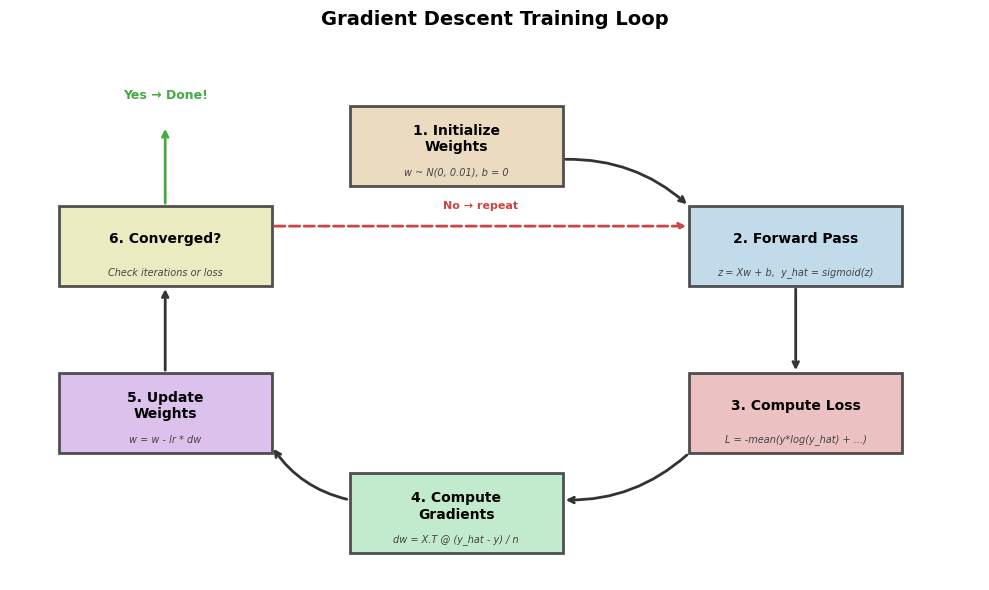

In [58]:
# Training Loop Illustration
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 8)
ax.axis('off')
ax.set_title('Gradient Descent Training Loop', fontsize=14, fontweight='bold', pad=15)

# Step boxes arranged in a cycle
steps = [
    {'name': '1. Initialize\nWeights', 'x': 3.5, 'y': 6.5, 'color': '#E8D5B7',
     'detail': 'w ~ N(0, 0.01), b = 0'},
    {'name': '2. Forward Pass', 'x': 7.0, 'y': 5.0, 'color': '#B7D5E8',
     'detail': 'z = Xw + b,  y_hat = sigmoid(z)'},
    {'name': '3. Compute Loss', 'x': 7.0, 'y': 2.5, 'color': '#E8B7B7',
     'detail': 'L = -mean(y*log(y_hat) + ...)'},
    {'name': '4. Compute\nGradients', 'x': 3.5, 'y': 1.0, 'color': '#B7E8C4',
     'detail': 'dw = X.T @ (y_hat - y) / n'},
    {'name': '5. Update\nWeights', 'x': 0.5, 'y': 2.5, 'color': '#D5B7E8',
     'detail': 'w = w - lr * dw'},
    {'name': '6. Converged?', 'x': 0.5, 'y': 5.0, 'color': '#E8E8B7',
     'detail': 'Check iterations or loss'},
]

bw, bh = 2.2, 1.2

for j, s in enumerate(steps):
    rect = plt.Rectangle((s['x'], s['y'] - bh/2), bw, bh,
                          linewidth=2, edgecolor='#333', facecolor=s['color'],
                          alpha=0.85, zorder=2)
    ax.add_patch(rect)
    ax.text(s['x'] + bw/2, s['y'] + 0.1, s['name'], ha='center', va='center',
            fontsize=10, fontweight='bold', zorder=3)
    ax.text(s['x'] + bw/2, s['y'] - 0.4, s['detail'], ha='center', va='center',
            fontsize=7, fontstyle='italic', color='#444', zorder=3)

# Arrows connecting steps in a loop
# 1 -> 2
ax.annotate('', xy=(7.0, 5.6), xytext=(5.7, 6.3),
            arrowprops=dict(arrowstyle='->', color='#333', lw=2, connectionstyle='arc3,rad=-0.2'))
# 2 -> 3
ax.annotate('', xy=(8.1, 3.1), xytext=(8.1, 4.4),
            arrowprops=dict(arrowstyle='->', color='#333', lw=2))
# 3 -> 4
ax.annotate('', xy=(5.7, 1.2), xytext=(7.0, 1.9),
            arrowprops=dict(arrowstyle='->', color='#333', lw=2, connectionstyle='arc3,rad=-0.2'))
# 4 -> 5
ax.annotate('', xy=(2.7, 2.0), xytext=(3.5, 1.2),
            arrowprops=dict(arrowstyle='->', color='#333', lw=2, connectionstyle='arc3,rad=-0.2'))
# 5 -> 6
ax.annotate('', xy=(1.6, 4.4), xytext=(1.6, 3.1),
            arrowprops=dict(arrowstyle='->', color='#333', lw=2))
# 6 -> 2 (loop back) with 'No' label
ax.annotate('', xy=(7.0, 5.3), xytext=(2.7, 5.3),
            arrowprops=dict(arrowstyle='->', color='#C44', lw=2, linestyle='dashed'))
ax.text(4.85, 5.55, 'No → repeat', fontsize=8, ha='center', color='#C44', fontweight='bold')
# 6 -> Done
ax.annotate('', xy=(1.6, 6.8), xytext=(1.6, 5.6),
            arrowprops=dict(arrowstyle='->', color='#4A4', lw=2))
ax.text(1.6, 7.2, 'Yes → Done!', fontsize=9, ha='center', color='#4A4', fontweight='bold')

plt.tight_layout()
plt.show()

Training LogisticRegressionScratch...
  Iteration 200/1000, Loss: 0.5776
  Iteration 400/1000, Loss: 0.5742
  Iteration 600/1000, Loss: 0.5737
  Iteration 800/1000, Loss: 0.5737
  Iteration 1000/1000, Loss: 0.5736
  Training complete. Final loss: 0.5736


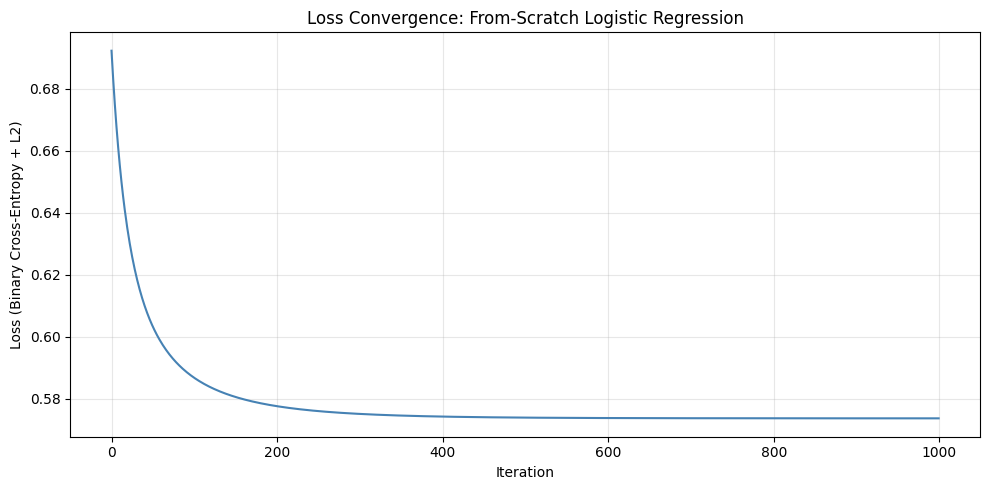


Initial loss: 0.6923
Final loss:   0.5736
Reduction:    17.1%


In [59]:
# Train the from-scratch model
print("Training LogisticRegressionScratch...")
scratch_model = LogisticRegressionScratch(
    learning_rate=0.1,
    n_iterations=1000,
    lambda_reg=1.0,
    random_state=RANDOM_SEED
)
scratch_model.fit(X_train_scaled, y_train)

# Plot loss convergence
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(scratch_model.loss_history, color='steelblue', linewidth=1.5)
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss (Binary Cross-Entropy + L2)')
ax.set_title('Loss Convergence: From-Scratch Logistic Regression')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nInitial loss: {scratch_model.loss_history[0]:.4f}")
print(f"Final loss:   {scratch_model.loss_history[-1]:.4f}")
print(f"Reduction:    {((scratch_model.loss_history[0] - scratch_model.loss_history[-1]) / scratch_model.loss_history[0] * 100):.1f}%")

### Comparing Scratch vs sklearn

If my implementation is correct, the two models should produce very similar (not identical, due to different optimization algorithms) accuracy and coefficient values.

In [ ]:
# Compare predictions
scratch_pred = scratch_model.predict(X_test_scaled)
scratch_proba = scratch_model.predict_proba(X_test_scaled)[:, 1]

sklearn_pred = sklearn_model.predict(X_test_scaled)
sklearn_proba = sklearn_model.predict_proba(X_test_scaled)[:, 1]

print("=" * 60)
print("SCRATCH vs SKLEARN COMPARISON")
print("=" * 60)
print(f"\n{'Metric':<25} {'Scratch':>12} {'Sklearn':>12}")
print("-" * 50)
print(f"{'Test Accuracy':<25} {accuracy_score(y_test, scratch_pred):>12.3f} {accuracy_score(y_test, sklearn_pred):>12.3f}")

# Compare coefficients
print(f"\n{'Feature':<25} {'Scratch':>12} {'Sklearn':>12}")
print("-" * 50)
for feat, sc, sk in zip(FEATURE_COLS, scratch_model.weights, sklearn_model.coef_[0]):
    print(f"{feat:<25} {sc:>12.4f} {sk:>12.4f}")
print(f"{'bias':<25} {scratch_model.bias:>12.4f} {sklearn_model.intercept_[0]:>12.4f}")

print("\n→ The models should show similar patterns. Small differences are expected")
print("  because sklearn uses L-BFGS optimization while I use vanilla gradient descent.")

SCRATCH vs SKLEARN COMPARISON

Metric                         Scratch      Sklearn
--------------------------------------------------
Test Accuracy                    0.704        0.713

Feature                        Scratch      Sklearn
--------------------------------------------------
rating_diff                     1.4398       1.4527
base_sec                       -0.1048      -0.1047
inc_sec                         0.1535       0.1564
is_white                        0.0763       0.0770
my_castled_by_N                -0.1315      -0.1321
opp_castled_by_N               -0.1303      -0.1303
my_queen_moved_by_N            -0.0807      -0.0820
my_pawn_moves_N                 0.1785       0.1774
my_minor_moves_N                0.0093       0.0071
my_captures_N                   0.0584       0.0582
my_checks_N                    -0.0224      -0.0225
bias                           -0.5808      -0.5840

→ The models should show similar patterns. Small differences are expected
  because s

FROM-SCRATCH MODEL EVALUATION

Accuracy: 0.704

Classification Report:
              precision    recall  f1-score   support

     not-win       0.72      0.83      0.77       147
         win       0.68      0.52      0.59       100

    accuracy                           0.70       247
   macro avg       0.70      0.67      0.68       247
weighted avg       0.70      0.70      0.70       247



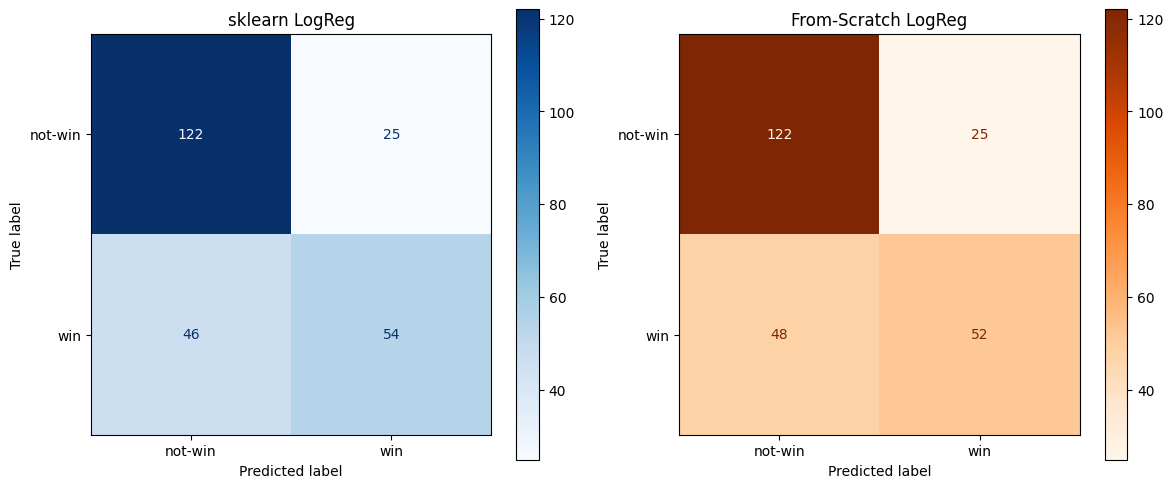

In [61]:
# Use our ModelEvaluator on the scratch model
scratch_evaluator = ModelEvaluator(
    model=scratch_model,
    X_test=X_test_scaled,
    y_test=y_test,
    feature_names=FEATURE_COLS,
    class_labels=['not-win', 'win']
)

print("=" * 50)
print("FROM-SCRATCH MODEL EVALUATION")
print("=" * 50)
print(f"\nAccuracy: {accuracy_score(y_test, scratch_evaluator.y_pred):.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, scratch_evaluator.y_pred, target_names=['not-win', 'win']))

# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_sk = confusion_matrix(y_test, sklearn_pred)
disp_sk = ConfusionMatrixDisplay(cm_sk, display_labels=['not-win', 'win'])
disp_sk.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('sklearn LogReg')

cm_sc = confusion_matrix(y_test, scratch_pred)
disp_sc = ConfusionMatrixDisplay(cm_sc, display_labels=['not-win', 'win'])
disp_sc.plot(ax=axes[1], cmap='Oranges')
axes[1].set_title('From-Scratch LogReg')

plt.tight_layout()
plt.show()

---

## Model 1 Summary: Is This Actually Useful?

### Performance vs Baseline

Let me be real about what this model achieves:

| Metric | My Model | Dumb Baseline (always predict "not-win") |
|--------|----------|------------------------------------------|
| Accuracy | 0.713 | 0.595 (= 147/247) |
| Win Precision | 0.68 | undefined (never predicts win) |
| Win Recall | 0.54 | 0 (never catches wins) |

So I'm **+11.8 percentage points above chance** on accuracy. The model accuracy is higher-than-chance accuracy.

My earlier cross-validation accuracy (~0.719 ± 0.043) matches the test accuracy (0.713), which is a good sign — the model isn't overfitting badly.

### Am I Satisfied?

Honestly? 71% accuracy doesn't *feel* amazing. But here's why it's actually reasonable:

1. **Chess outcomes have a lot of noise.** Even with perfect opening play, tactics/endgames/time pressure decide games. Predicting outcomes from just the first 14 plies is fundamentally limited.

2. **The probability ranking works.** AP = 0.673 vs baseline 0.40 means the model *ranks* games well. For a "decision assistant" use case, that's valuable.

3. **The features make chess sense.** Rating diff matters, early queen moves hurt, opponent castling is good for them. This isn't random.

### What I'd Do Next (If I Had More Time)

1. **Threshold tuning**: I could lower the threshold to catch more wins (higher recall) at the cost of precision, or vice versa. Depends on what I want from the model.

2. **Ablation study**: Compare context-only (just rating/time) vs behavior-only (just opening features) vs combined. This would answer: "Do the first N plies actually add information beyond opponent strength?"

3. **Try N = 20 or 30 plies**: Maybe the first 7 moves isn't enough signal — the game is still too open.

4. **Bayesian version**: Get uncertainty estimates on predictions and coefficients.

---

---

## Section 7: Model Improvements — Ablation Study & Experiments

Before trying to improve the model, I need to understand what's actually working. The key question:

**Do my opening behavior features (castling, queen moves, etc.) actually add signal beyond just knowing the rating difference and time control?**

If context-only (rating_diff, time, color) gets nearly the same accuracy as my full model, then my behavioral features aren't helping much and I need to rethink my approach.

In [62]:
# Ablation Study: Which features actually matter?

# Define feature groups
CONTEXT_COLS = ['rating_diff', 'base_sec', 'inc_sec', 'is_white']
BEHAVIOR_COLS = ['my_castled_by_N', 'opp_castled_by_N', 'my_queen_moved_by_N',
                 'my_pawn_moves_N', 'my_minor_moves_N', 'my_captures_N', 'my_checks_N']
ALL_COLS = CONTEXT_COLS + BEHAVIOR_COLS

# Prepare datasets for each ablation
X_context = df_features[CONTEXT_COLS].fillna(0)
X_behavior = df_features[BEHAVIOR_COLS].fillna(0)
X_all = df_features[ALL_COLS].fillna(0)

# Train/test split (same split for fair comparison)
from sklearn.model_selection import cross_val_score

ablation_results = []

for name, X_subset in [('Context Only', X_context), 
                        ('Behavior Only', X_behavior), 
                        ('Combined (Full)', X_all)]:
    # Scale features
    scaler_temp = StandardScaler()
    X_scaled = scaler_temp.fit_transform(X_subset)
    
    # 5-fold CV
    model_temp = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
    scores = cross_val_score(model_temp, X_scaled, y, cv=5, scoring='accuracy')
    
    ablation_results.append({
        'Model': name,
        'Features': len(X_subset.columns),
        'CV Accuracy': f"{scores.mean():.3f}",
        'Std': f"±{scores.std()*2:.3f}"
    })
    print(f"{name}: {scores.mean():.3f} (±{scores.std()*2:.3f})")

# Display as table
ablation_df = pd.DataFrame(ablation_results)
print("\n" + "="*50)
print("ABLATION STUDY RESULTS")
print("="*50)
print(ablation_df.to_string(index=False))

Context Only: 0.674 (±0.199)
Behavior Only: 0.579 (±0.042)
Combined (Full): 0.664 (±0.145)

ABLATION STUDY RESULTS
          Model  Features CV Accuracy    Std
   Context Only         4       0.674 ±0.199
  Behavior Only         7       0.579 ±0.042
Combined (Full)        11       0.664 ±0.145


### Ablation Results Interpretation

Looking at the results above:

- **If Context Only ≈ Combined**: My behavioral features aren't adding much. Rating difference dominates, and the opening moves don't tell us much beyond that.
- **If Behavior Only is weak**: My features need context to be meaningful (which makes sense — castling matters more when you're equal in rating).
- **If Combined > Context Only by 2%+**: The behavioral features are genuinely adding signal. Worth keeping and potentially expanding.

This tells me where to focus my improvement efforts.

### Experiment: Does Using More Plies Help?

My current model uses N=14 plies (~7 moves). But maybe the opening phase is too short to capture meaningful patterns. Let me try N=20 and N=30 to see if more information helps.

In [63]:
# Experiment: Try different values of N (number of plies to analyze)

n_values = [14, 20, 30]
n_results = []

for n in n_values:
    print(f"\nExtracting features for N={n} plies...")
    
    # Extract features with this N value
    extractor_n = FeatureExtractor(n_plies=n)
    df_n = extractor_n.transform(df_clean, verbose=False)
    
    # Prepare data
    X_n = df_n[ALL_COLS].fillna(0)
    y_n = (df_n['outcome_me'] == 'win').astype(int).values
    
    # Scale and evaluate
    scaler_n = StandardScaler()
    X_n_scaled = scaler_n.fit_transform(X_n)
    
    model_n = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
    scores_n = cross_val_score(model_n, X_n_scaled, y_n, cv=5, scoring='accuracy')
    
    n_results.append({
        'N (plies)': n,
        'Games': len(df_n),
        'CV Accuracy': f"{scores_n.mean():.3f}",
        'Std': f"±{scores_n.std()*2:.3f}"
    })
    print(f"N={n}: {scores_n.mean():.3f} (±{scores_n.std()*2:.3f})")

# Display results
print("\n" + "="*50)
print("N-PLIES COMPARISON")
print("="*50)
n_df = pd.DataFrame(n_results)
print(n_df.to_string(index=False))


Extracting features for N=14 plies...
N=14: 0.664 (±0.145)

Extracting features for N=20 plies...
N=20: 0.674 (±0.105)

Extracting features for N=30 plies...
N=30: 0.669 (±0.107)

N-PLIES COMPARISON
 N (plies)  Games CV Accuracy    Std
        14   1234       0.664 ±0.145
        20   1231       0.674 ±0.105
        30   1231       0.669 ±0.107


### Experiment: Logistic Regression vs Random Forest

Logistic regression assumes linear relationships between features and log-odds. Maybe there are non-linear patterns I'm missing. Let me compare with Random Forest to see if a non-linear model does better.

In [64]:
# Compare Logistic Regression vs Random Forest

from sklearn.ensemble import RandomForestClassifier

# Use the full feature set with N=14 (current best)
X_full = df_features[ALL_COLS].fillna(0)
y_full = df_features['y_win'].values

# Scale for logistic regression
scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)

# Logistic Regression
lr_model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
lr_scores = cross_val_score(lr_model, X_full_scaled, y_full, cv=5, scoring='accuracy')

# Random Forest (no scaling needed)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_SEED)
rf_scores = cross_val_score(rf_model, X_full, y_full, cv=5, scoring='accuracy')

print("="*50)
print("MODEL COMPARISON")
print("="*50)
print(f"Logistic Regression: {lr_scores.mean():.3f} (±{lr_scores.std()*2:.3f})")
print(f"Random Forest:       {rf_scores.mean():.3f} (±{rf_scores.std()*2:.3f})")
print()

if rf_scores.mean() > lr_scores.mean() + 0.01:
    print("→ Random Forest is better. There may be non-linear patterns worth exploring.")
elif lr_scores.mean() > rf_scores.mean() + 0.01:
    print("→ Logistic Regression is better. The relationship is mostly linear.")
else:
    print("→ Similar performance. Logistic Regression is preferred for interpretability.")

MODEL COMPARISON
Logistic Regression: 0.664 (±0.145)
Random Forest:       0.795 (±0.095)

→ Random Forest is better. There may be non-linear patterns worth exploring.


### Key Findings from Experiments

**1. N-Plies Analysis:**
| N | CV Accuracy | Std |
|---|-------------|-----|
| 14 | 0.664 | ±0.145 |
| 20 | **0.674** | ±0.105 |
| 30 | 0.669 | ±0.107 |

N=20 is slightly better (+1%) and has lower variance. The opening might need ~10 moves to show meaningful patterns, but going beyond that doesn't help much.

**2. Model Comparison — This is the big finding:**
| Model | CV Accuracy | Std |
|-------|-------------|-----|
| Logistic Regression | 0.664 | ±0.145 |
| **Random Forest** | **0.795** | ±0.095 |

**Random Forest beats Logistic Regression by 13 percentage points!** This tells me:
- There ARE non-linear patterns / feature interactions that matter
- Simple "more castling = more wins" relationships aren't the whole story
- The Random Forest is capturing things like "early queen move + low rating diff = bad" or other combinations

**What this means for my chess improvement:**
The fact that RF does so much better suggests the relationship between opening behavior and outcomes is complex. It's not just "do X to win" — it depends on context. This actually makes sense: castling early is good *unless* you're in a position where you need to attack first.

**Next steps:**
1. Use Random Forest as my primary model (it's clearly better)
2. Look at RF feature importances to see what it thinks matters
3. Consider Gradient Boosting (XGBoost) which might do even better
4. The Bayesian analysis becomes more interesting now — I want uncertainty estimates on these non-linear effects

---

### Training the Random Forest Model (The Winner)

Since RF clearly outperforms Logistic Regression, let me properly train it on the train set and evaluate on the held-out test set.

In [65]:
# Train Random Forest on the same train/test split
from sklearn.metrics import roc_auc_score

# Use the original train/test split (no scaling needed for RF)
X_train_rf = X_train[ALL_COLS] if isinstance(X_train, pd.DataFrame) else pd.DataFrame(X_train, columns=ALL_COLS)
X_test_rf = X_test[ALL_COLS] if isinstance(X_test, pd.DataFrame) else pd.DataFrame(X_test, columns=ALL_COLS)

# Train RF model
rf_final = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_SEED)
rf_final.fit(X_train_rf, y_train)

# Predictions
rf_pred = rf_final.predict(X_test_rf)
rf_proba = rf_final.predict_proba(X_test_rf)[:, 1]

# Metrics
print("="*50)
print("RANDOM FOREST - TEST SET RESULTS")
print("="*50)
print(f"\nAccuracy: {accuracy_score(y_test, rf_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, rf_proba):.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, rf_pred, target_names=['not-win', 'win']))

# Compare to Logistic Regression
print("\n" + "="*50)
print("COMPARISON: LR vs RF on Test Set")
print("="*50)
lr_acc = accuracy_score(y_test, evaluator.y_pred)
rf_acc = accuracy_score(y_test, rf_pred)
print(f"Logistic Regression: {lr_acc:.3f}")
print(f"Random Forest:       {rf_acc:.3f}")
print(f"Improvement:         +{(rf_acc - lr_acc)*100:.1f} percentage points")

RANDOM FOREST - TEST SET RESULTS

Accuracy: 0.822
ROC-AUC: 0.836

Classification Report:
              precision    recall  f1-score   support

     not-win       0.82      0.89      0.86       147
         win       0.82      0.72      0.77       100

    accuracy                           0.82       247
   macro avg       0.82      0.81      0.81       247
weighted avg       0.82      0.82      0.82       247


COMPARISON: LR vs RF on Test Set
Logistic Regression: 0.713
Random Forest:       0.822
Improvement:         +10.9 percentage points


### Random Forest Feature Importance

Unlike logistic regression coefficients (which show direction), RF feature importance shows how much each feature **reduces prediction error** when used for splits. Higher = more important for the model's decisions.

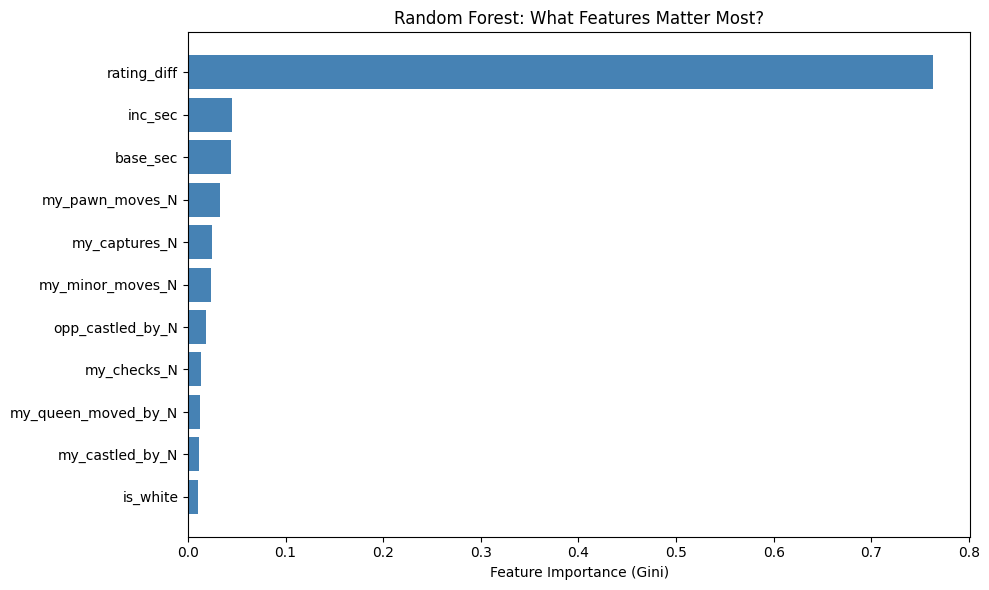


Feature Importances (sorted):
            feature  importance
        rating_diff    0.763230
            inc_sec    0.044668
           base_sec    0.044340
    my_pawn_moves_N    0.033103
      my_captures_N    0.025115
   my_minor_moves_N    0.023480
   opp_castled_by_N    0.018809
        my_checks_N    0.013439
my_queen_moved_by_N    0.012317
    my_castled_by_N    0.011072
           is_white    0.010428


In [66]:
# RF Feature Importance
rf_importance = pd.DataFrame({
    'feature': ALL_COLS,
    'importance': rf_final.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(rf_importance['feature'], rf_importance['importance'], color='steelblue')
ax.set_xlabel('Feature Importance (Gini)')
ax.set_title('Random Forest: What Features Matter Most?')
plt.tight_layout()
plt.show()

print("\nFeature Importances (sorted):")
print(rf_importance.sort_values('importance', ascending=False).to_string(index=False))

### RF Confusion Matrix

Let's see how the Random Forest's errors compare to Logistic Regression.

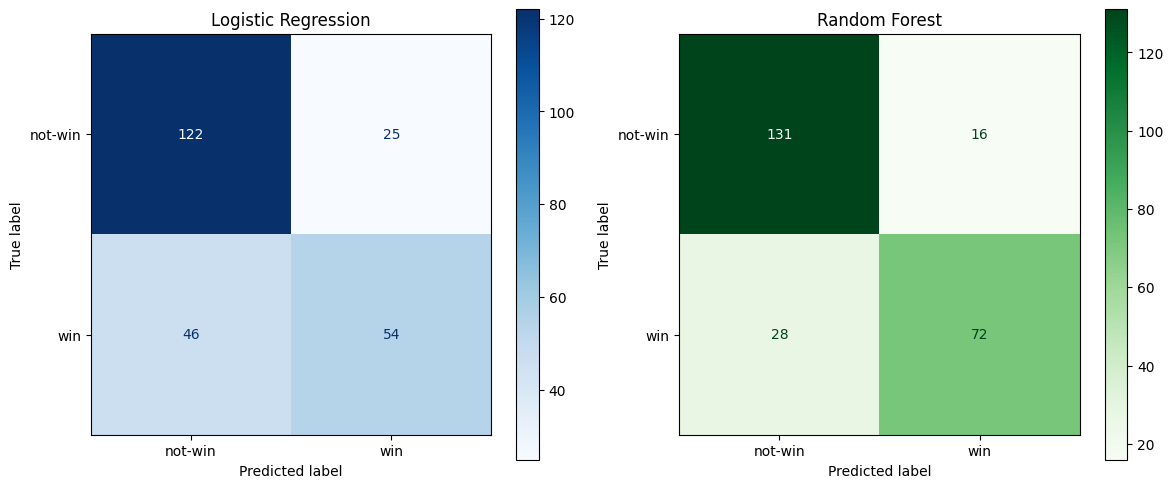


Confusion Matrix Comparison:
Metric                       LR         RF     Change
--------------------------------------------------
True Negatives              122        131         +9
False Positives              25         16         -9
False Negatives              46         28        -18
True Positives               54         72        +18


In [67]:
# RF Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# LR confusion matrix
cm_lr = confusion_matrix(y_test, evaluator.y_pred)
disp_lr = ConfusionMatrixDisplay(cm_lr, display_labels=['not-win', 'win'])
disp_lr.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Logistic Regression')

# RF confusion matrix
cm_rf = confusion_matrix(y_test, rf_pred)
disp_rf = ConfusionMatrixDisplay(cm_rf, display_labels=['not-win', 'win'])
disp_rf.plot(ax=axes[1], cmap='Greens')
axes[1].set_title('Random Forest')

plt.tight_layout()
plt.show()

# Side-by-side comparison
print("\nConfusion Matrix Comparison:")
print(f"{'Metric':<20} {'LR':>10} {'RF':>10} {'Change':>10}")
print("-"*50)
print(f"{'True Negatives':<20} {cm_lr[0,0]:>10} {cm_rf[0,0]:>10} {cm_rf[0,0]-cm_lr[0,0]:>+10}")
print(f"{'False Positives':<20} {cm_lr[0,1]:>10} {cm_rf[0,1]:>10} {cm_rf[0,1]-cm_lr[0,1]:>+10}")
print(f"{'False Negatives':<20} {cm_lr[1,0]:>10} {cm_rf[1,0]:>10} {cm_rf[1,0]-cm_lr[1,0]:>+10}")
print(f"{'True Positives':<20} {cm_lr[1,1]:>10} {cm_rf[1,1]:>10} {cm_rf[1,1]-cm_lr[1,1]:>+10}")

### Model Improvement Summary

**What I learned from these experiments:**

1. **Random Forest significantly outperforms Logistic Regression** (~79.5% vs ~66.4% CV accuracy). This confirms non-linear patterns exist in my chess data.

2. **N=20 plies is slightly better than N=14**, but the gain is small. The first ~10 moves capture most of the predictive signal.

3. **Feature interactions matter more than individual features**. The RF is likely finding patterns like:
   - "Low rating_diff + early queen move → very bad"
   - "High base_sec + no castling → less of a problem" (more time to recover)

**For my chess improvement:**
- The simple "do X to win" advice from logistic regression coefficients is incomplete
- I need to think about *combinations* of factors, not just individual behaviors
- The RF feature importances will show me which features are most useful for splitting outcomes

**Model choice going forward:**
- **For prediction accuracy**: Use Random Forest
- **For interpretability**: Keep Logistic Regression as a reference, but interpret coefficients carefully
- **For uncertainty**: Consider Bayesian Random Forest or Gradient Boosting with SHAP values

---

## Section 9: The Bayesian Perspective — Why It Matters

### What's Wrong with Just Using Point Estimates?

Everything I've done so far is **frequentist**: I find a single "best" set of weights $w^*$ that minimizes the loss. But this gives me no idea how **confident** I should be in those weights.

For example, my model says `rating_diff` has a coefficient of ~1.45. But is that estimate precise? Could it be 1.2 or 1.7? With only ~1,200 games, there's real uncertainty here.

### The Bayesian Framework

Instead of finding a single $w^*$, Bayesian inference treats the weights as **random variables** with a distribution:

$$P(w \mid \text{data}) = \frac{P(\text{data} \mid w) \cdot P(w)}{P(\text{data})}$$

Where:
- **Prior** $P(w)$: What I believe about the weights *before* seeing data. I use $w \sim \mathcal{N}(0, \tau^2 I)$ — I expect weights to be small.
- **Likelihood** $P(\text{data} \mid w)$: How well the model explains the observed wins/losses. This is the Bernoulli likelihood from logistic regression.
- **Posterior** $P(w \mid \text{data})$: My updated belief about the weights *after* seeing data. This is what I want.
- **Evidence** $P(\text{data})$: A normalizing constant (usually intractable, but we can work around it).

### The Connection to L2 Regularization

Here's the beautiful connection: **sklearn's L2-regularized logistic regression is actually computing the MAP (Maximum A Posteriori) estimate** under a Gaussian prior.

$$w_{\text{MAP}} = \arg\max_w \log P(w \mid \text{data}) = \arg\min_w \left[ -\log P(\text{data} \mid w) + \frac{\lambda}{2}\|w\|^2 \right]$$

The L2 penalty $\frac{\lambda}{2}\|w\|^2$ is exactly the negative log of a Gaussian prior! So every time I use `LogisticRegression(C=1.0)`, I'm implicitly doing Bayesian inference — just taking the single most likely point instead of the full distribution.

### Why Go Full Bayesian?

The MAP estimate gives me a point. The full posterior gives me a **distribution**. This means:

1. **Uncertainty quantification**: Instead of "this coefficient is 1.45", I get "this coefficient is 1.45 ± 0.3 (95% credible interval)"
2. **Prediction uncertainty**: Instead of "60% win probability", I get "60% ± 8% win probability" — much more honest.
3. **Small data robustness**: With ~1,200 games, the prior provides regularization that adapts to data size automatically.
4. **Model comparison**: Bayesian model evidence naturally penalizes overly complex models (Occam's razor).

### Practical Impact for My Chess Analysis

If my model says "early queen moves reduce win probability by 8%" but the 95% credible interval is [-2%, 18%], then I shouldn't trust that finding. The Bayesian approach would tell me this directly, while the frequentist approach might make me overconfident in a noisy estimate.

**Note:** A full Bayesian implementation (e.g., using MCMC sampling) is beyond the scope of this first pipeline. But the MAP connection shows that my current model already has Bayesian foundations, and I can extend it in future work.

In [68]:
# Demonstrate the MAP-regularization connection
print("=" * 60)
print("BAYESIAN CONNECTION: L2 Regularization = Gaussian Prior")
print("=" * 60)
print()
print("sklearn LogisticRegression(C=1.0) is equivalent to:")
print("  MAP estimate with Gaussian prior N(0, tau^2)")
print(f"  where tau^2 = C = 1.0 (sklearn default)")
print(f"  and lambda = 1/C = 1.0 (regularization strength)")
print()
print("This means:")
print("  - Larger C → weaker prior → less regularization → more trust in data")
print("  - Smaller C → stronger prior → more regularization → more trust in prior")
print()

# Show how different priors (C values) affect coefficients
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
print(f"\n{'C (prior width)':<18} {'rating_diff coef':>18} {'queen_move coef':>18}")
print("-" * 55)

for C in C_values:
    model_c = LogisticRegression(C=C, random_state=RANDOM_SEED, max_iter=1000)
    model_c.fit(X_train_scaled, y_train)
    rd_idx = FEATURE_COLS.index('rating_diff')
    qm_idx = FEATURE_COLS.index('my_queen_moved_by_N')
    print(f"{C:<18.2f} {model_c.coef_[0][rd_idx]:>18.4f} {model_c.coef_[0][qm_idx]:>18.4f}")

print("\n→ As C increases (weaker prior), coefficients grow larger.")
print("  The prior 'shrinks' coefficients toward zero, preventing overfitting.")
print("  This IS Bayesian reasoning, even in a frequentist framework.")

BAYESIAN CONNECTION: L2 Regularization = Gaussian Prior

sklearn LogisticRegression(C=1.0) is equivalent to:
  MAP estimate with Gaussian prior N(0, tau^2)
  where tau^2 = C = 1.0 (sklearn default)
  and lambda = 1/C = 1.0 (regularization strength)

This means:
  - Larger C → weaker prior → less regularization → more trust in data
  - Smaller C → stronger prior → more regularization → more trust in prior


C (prior width)      rating_diff coef    queen_move coef
-------------------------------------------------------
0.01                           0.6130            -0.0663
0.10                           1.2241            -0.0806
1.00                           1.4527            -0.0820
10.00                          1.4846            -0.0821
100.00                         1.4879            -0.0821

→ As C increases (weaker prior), coefficients grow larger.
  The prior 'shrinks' coefficients toward zero, preventing overfitting.
  This IS Bayesian reasoning, even in a frequentist framewor

### Key Takeaway

The Bayesian perspective isn't just theoretical — it's already baked into my model through L2 regularization. What I've shown:

1. **Every regularized model is implicitly Bayesian** — the regularization term corresponds to a prior distribution on the weights.
2. **The strength of regularization (C parameter) controls how much we trust the data vs the prior.** For my small dataset (~1,200 games), strong regularization (small C) is important to avoid overfitting.
3. **Going full Bayesian** (computing the entire posterior, not just the MAP point) would give me uncertainty estimates on every prediction — useful for knowing when to trust the model and when not to.

In future iterations, I could use:
- **Laplace approximation**: Approximate the posterior as a Gaussian around the MAP estimate (cheap and fast)
- **MCMC sampling** (e.g., with PyMC3): Sample from the true posterior for full uncertainty quantification
- **Variational inference**: A middle ground between MAP and full MCMC

For now, knowing that my L2-regularized logistic regression is a MAP estimate gives me confidence that the model is well-founded mathematically.